# 信贷申请评分卡_A卡案例

主要项目流程：数据获取、数据清洗(特征初筛)、特征工程、模型建立与评价等

In [103]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sn
import catboost as cat
import lightgbm as lgb
import xgboost as xgb
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.model_selection import train_test_split
from sklearn.grid_search import GridSearchCV
from sklearn.metrics import accuracy_score, recall_score, f1_score, precision_score
from sklearn.metrics import confusion_matrix, roc_curve, auc

In [78]:
% config ZMQInteractiveShell.ast_node_interactivity='all'

# 1.数据获取

In [2]:
# 数据基本描述：信贷申请数据--42535个样本，144个特征

In [3]:
data = pd.read_excel('LoanStats_2018Q3.xlsx')
data.shape

(42535, 144)

In [4]:
# 特征列表
feature_list = list(data)
print(feature_list)
df = data.copy()
df.head()

['id', 'loan_amnt', 'funded_amnt', 'funded_amnt_inv', 'term', 'int_rate', 'installment', 'grade', 'sub_grade', 'emp_title', 'emp_length', 'home_ownership', 'annual_inc', 'verification_status', 'issue_d', 'loan_status', 'pymnt_plan', 'url', 'desc', 'purpose', 'title', 'zip_code', 'addr_state', 'dti', 'delinq_2yrs', 'earliest_cr_line', 'inq_last_6mths', 'mths_since_last_delinq', 'mths_since_last_record', 'open_acc', 'pub_rec', 'revol_bal', 'revol_util', 'total_acc', 'initial_list_status', 'out_prncp', 'out_prncp_inv', 'total_pymnt', 'total_pymnt_inv', 'total_rec_prncp', 'total_rec_int', 'total_rec_late_fee', 'recoveries', 'collection_recovery_fee', 'last_pymnt_d', 'last_pymnt_amnt', 'next_pymnt_d', 'last_credit_pull_d', 'collections_12_mths_ex_med', 'mths_since_last_major_derog', 'policy_code', 'application_type', 'annual_inc_joint', 'dti_joint', 'verification_status_joint', 'acc_now_delinq', 'tot_coll_amt', 'tot_cur_bal', 'open_acc_6m', 'open_act_il', 'open_il_12m', 'open_il_24m', 'mths

,id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,emp_title,...,hardship_payoff_balance_amount,hardship_last_payment_amount,disbursement_method,debt_settlement_flag,debt_settlement_flag_date,settlement_status,settlement_date,settlement_amount,settlement_percentage,settlement_term
0,1,5000,5000,4975.0,36 months,0.1065,162.87,B,B2,NaN,...,NaN,NaN,Cash,N,NaT,NaN,NaT,NaN,NaN,NaN
1,2,2500,2500,2500.0,60 months,0.1527,59.83,C,C4,Ryder,...,NaN,NaN,Cash,N,NaT,NaN,NaT,NaN,NaN,NaN
2,3,2400,2400,2400.0,36 months,0.1596,84.33,C,C5,NaN,...,NaN,NaN,Cash,N,NaT,NaN,NaT,NaN,NaN,NaN
3,4,10000,10000,10000.0,36 months,0.1349,339.31,C,C1,AIR RESOURCES BOARD,...,NaN,NaN,Cash,N,NaT,NaN,NaT,NaN,NaN,NaN
4,5,3000,3000,3000.0,60 months,0.1269,67.79,B,B5,University Medical Group,...,NaN,NaN,Cash,N,NaT,NaN,NaT,NaN,NaN,NaN


# 2.数据清洗（特征初筛）

In [5]:
# 2.1 申请评分卡使用的数据不能是借款人借款后的信息，需删除18个特征
del_feature_list = ['sub_grade','grade','initial_list_status','out_prncp','out_prncp_inv','total_pymnt','total_pymnt_inv',
                    'total_rec_prncp','total_rec_int','total_rec_late_fee','recoveries','collection_recovery_fee','last_pymnt_d',
                    'last_pymnt_amnt','last_credit_pull_d','collections_12_mths_ex_med','policy_code','disbursement_method']
print(df.shape)
df_01 = df.copy().drop(columns=del_feature_list, axis=1)
df_01.shape

(42535, 144)


(42535, 126)

In [6]:
# 2.2 删除客户隐私的字段:['emp_title','title']
customer_info = ['emp_title','title']
df_02 = df_01.drop(columns=customer_info, axis=1)
df_02.shape

(42535, 124)

In [7]:
# 2.3 去重，删除空行
df_03 = df_02.drop_duplicates('id').dropna(axis=0, how='all')
df_03.shape

(42535, 124)

In [8]:
# 2.4 删除缺失率大于0.95的字段
# is_null = [df_03[i_feature].isnull().sum() for i_feature in list(df_03)]
cols_null = []
for col_null in df_03.columns:
    if df_03[col_null].isnull().sum() > (df_03.shape[0])*0.95:
        cols_null.append(col_null)
print(len(cols_null))
df_04 = df_03.drop(cols_null, axis=1)
df_04.shape

86


(42535, 38)

In [9]:
# 例：唯一值
# 2.5 判断每个特征值的分布，若存在某一个值占比超过95%，则删除(分箱前提)
col_handle = []
for col_ in df_04.columns:
    if df_04[col_].value_counts().max() > df_04.shape[0]*0.95:
        col_handle.append(col_)
print(col_handle)
df_05 = df_04.drop(col_handle, axis=1)
df_05.shape

['pymnt_plan', 'application_type', 'acc_now_delinq', 'chargeoff_within_12_mths', 'delinq_amnt', 'tax_liens', 'hardship_flag', 'debt_settlement_flag']


(42535, 30)

In [10]:
# 2.6 删除id号
df_06 = df_05.drop('id', axis=1)
df_06.shape

(42535, 29)

In [11]:
# 2.7 查看借款期限，并选出借款36期的样本
print(df_06['term'].value_counts())
df_06['term'] = df_06['term'].replace(' 36 months', 36).replace(' 60 months', 60)
df_final = df_06[df_06['term']==36]
df_final.shape

 36 months    31534
 60 months    11001
Name: term, dtype: int64


(31534, 29)

In [12]:
# 2.8 数据类型查看与转换
def obj_feature(df_final):
    obj_feature = []
    for obj_f in df_final.columns:
        if df_final[obj_f].dtypes == 'object':
            obj_feature.append(obj_f)
    print(obj_feature)
    return obj_feature

obj_feature = obj_feature(df_final)

['emp_length', 'home_ownership', 'verification_status', 'loan_status', 'desc', 'purpose', 'zip_code', 'addr_state', 'delinq_2yrs', 'total_acc']


In [13]:
# 特征值查看
# 1) emp_length--工作年限
df_finals = df_final.copy()
# print(df_finals['emp_length'].value_counts())
print(df_finals['emp_length'].unique())

def emp_length_new(x):
    if x=='< 1 year':
        return 0
    elif x=='1 year':
        return 1
    elif x=='10+ years':
        return 11
    elif str(x)=='nan':
        return np.nan
    else:
        return x.replace(' years', '')
    
df_finals['emp_length'] =df_finals['emp_length'].map(lambda x: emp_length_new(x))
df_finals['emp_length'].unique()
df_finals['emp_length'] = df_finals['emp_length'].apply(pd.to_numeric, errors='coerce')
# print('===================================')

# 2) home_ownership--房产权:类别型特征
# print(df_finals['home_ownership'].value_counts())
# print('===================================')

# 3) verification_status--验证状态:类别型特征
# print(df_finals['verification_status'].value_counts())
# print('===================================')

# 4) loan_status--贷款状态:y
# df_finals['loan_status'].value_counts()
df_finals['loan_status'] = df_finals['loan_status'].copy().map(lambda x: 1 if 'Charged Off' in x else 0)
# print(df_finals['loan_status'].value_counts())
# print('===================================')

# 5) desc--自然语言模块，暂不考虑
df_finals = df_finals.drop('desc', axis=1)
# print('===================================')

# 6) purpose--用途：类别型特征
# print(df_finals['purpose'].value_counts())
# print('===================================')

# 7) zip_code--邮政编码
df_finals = df_finals.drop('zip_code', axis=1)
# print('===================================')

# 8) addr_state--地址状态：类别型特征
# print(df_finals['addr_state'].value_counts())
# print('===================================')

# 9) delinq_2yrs：过去两年逾期次数
# print(df_finals['delinq_2yrs'].value_counts())
set(df_finals['delinq_2yrs'])
df_finals['delinq_2yrs'] = df_finals['delinq_2yrs'].apply(pd.to_numeric, errors='coerce')

# 10) total_acc
set(df_finals['total_acc'])
df_finals['total_acc'] = df_finals['total_acc'].apply(pd.to_numeric, errors='coerce')

['10+ years' '3 years' '9 years' '< 1 year' '4 years' '1 year' '6 years'
 '5 years' '2 years' '7 years' '8 years' nan]


In [14]:
# 2.9 特征衍生：loan_amnt贷款额度，annual_inc年收入（贷款收入比）
# df_finals[['loan_amnt','annual_inc', 'issue_d', 'earliest_cr_line', 'next_pymnt_d']]
df_finals['pnt_loan_annual'] = df_finals.loan_amnt/df_finals.annual_inc
print(df_finals.shape)
df_finals.columns

(31534, 28)


Index(['loan_amnt', 'funded_amnt', 'funded_amnt_inv', 'term', 'int_rate',
       'installment', 'emp_length', 'home_ownership', 'annual_inc',
       'verification_status', 'issue_d', 'loan_status', 'purpose',
       'addr_state', 'dti', 'delinq_2yrs', 'earliest_cr_line',
       'inq_last_6mths', 'mths_since_last_delinq', 'mths_since_last_record',
       'open_acc', 'pub_rec', 'revol_bal', 'revol_util', 'total_acc',
       'next_pymnt_d', 'pub_rec_bankruptcies', 'pnt_loan_annual'],
      dtype='object')

In [15]:
# 特征列表分类
# 离散(类别型)特征:home_ownership, verification_status, purpose, addr_state
char_feature = ['emp_length', 'home_ownership', 'verification_status', 'purpose', 'addr_state']

# 日期型特征：issue_d，earliest_cr_line，next_pymnt_d
time_feature = ['issue_d', 'earliest_cr_line', 'next_pymnt_d']
df_finals[time_feature] = df_finals[time_feature].apply(pd.to_datetime)

# 标签
df_label=['loan_status']

# 连续型特征
num_feature = df_finals.copy().columns.drop(time_feature).drop(char_feature).drop(df_label)
for i_f in num_feature:
    df_finals[i_f] = df_finals[i_f].apply(pd.to_numeric, errors='coerce')
print(len(num_feature))

19


In [16]:
# *数据探索
# 类别型(离散)特征: 每个特征值分布概率值
def data_distributed(df_finals, char_feature):
    rate_feature_all = []
    for col in char_feature:
        result = df_finals[col].value_counts()
        #print('char_feature_name:', col)
        rate_feature = []
        for v_i in range(len(result)):
            rate = result[v_i]/result.sum()
            rate_feature.append(rate)
        rate_feature = pd.Series(rate_feature).to_frame().reset_index().rename(columns={'index':'id', 0: 'rate'})
        result = pd.Series(result).to_frame().reset_index().reset_index().rename(columns={'level_0':'id', 'index':'f_name',
                                                                                          'home_ownership':'value_count'})
        rate_feature = pd.merge(result, rate_feature, on=['id']).drop('id', axis=1)
        rate_feature_all.append(rate_feature)
    return rate_feature_all

df_finals['emp_length'] = df_finals['emp_length'].astype('str')
# df_finals['emp_length'].dtypes
rate_feature_all = data_distributed(df_finals, char_feature)
# rate_feature_all

In [17]:
# 2.10 缺失值查看与处理
# 离散特征
print(df_finals[char_feature].isnull().sum())
print('==============next=============')

# 连续型特征
print(df_finals[num_feature].isnull().sum())
# 缺失值处理：-999填充
df_s = df_finals.fillna(-999)

emp_length             0
home_ownership         0
verification_status    0
purpose                0
addr_state             0
dtype: int64
==============next=============
loan_amnt                     0
funded_amnt                   0
funded_amnt_inv               0
term                          0
int_rate                      0
installment                   0
annual_inc                    4
dti                           0
delinq_2yrs                  30
inq_last_6mths               29
mths_since_last_delinq    19747
mths_since_last_record    28530
open_acc                     29
pub_rec                      29
revol_bal                     0
revol_util                   86
total_acc                    30
pub_rec_bankruptcies       1365
pnt_loan_annual               4
dtype: int64


In [18]:
# 重命名与定义y标签：贷款状态(好样本0，坏样本1)
df_s=df_s.rename(columns={'loan_status':'y'})
df_s['y'].value_counts()

0    27658
1     3876
Name: y, dtype: int64

# 3.特征工程

In [19]:
# 根据iv值、相关性、多重共线性等筛选特征

In [20]:
# 离散：计算每个特征的iv值
def cal_charf_iv(char_df, label):
#     print(char_df.shape, '\n====计算离散特征的iv值====')
    all_feature_iv = []
    char_feature_name = []
    for char_f in list(char_df):
        if char_f not in label:
            char_feature_name.append(char_f)
            #print('feature:', char_f)
            df = pd.concat([char_df[char_f], char_df[label]], axis=1)
            #print(df.shape)
            # 好样本统计
            good_df = df[df[label]==0]
            good_count = good_df[char_f].value_counts().to_frame().reset_index().rename(columns={'index':'char_value',char_f:'good_count'})
            # 坏样本统计
            bad_df = df[df[label]==1]
            bad_count = bad_df[char_f].value_counts().to_frame().reset_index().rename(columns={'index':'char_value',char_f:'bad_count'})
            # 整合
            result_df = pd.merge(good_count, bad_count, on=['char_value'])
            result_df['good_rate'] = result_df.good_count/result_df.good_count.sum() # 好客户的占比
            result_df['bad_rate'] = result_df.bad_count/result_df.bad_count.sum() # 坏客户的占比
            result_df['cum_good_rate'] = result_df.good_rate.cumsum()
            result_df['cum_bad_rate'] = result_df.bad_rate.cumsum()
            # 计算ks
            result_df['ks'] = round(abs(result_df.cum_good_rate - result_df.cum_bad_rate), 4)
            # 计算woe(优势比):ln(好客户的占比/坏客户的占比)*100%
            result_df['woe'] = np.log(result_df.good_rate/result_df.bad_rate)
            result_df['iv'] = (result_df.good_rate-result_df.bad_rate)*(result_df.woe)
            feature_iv = result_df.iv.sum()
            #print('feature_iv:',feature_iv)
            #print(str(char_f + ':'), feature_iv)
            all_feature_iv.append(feature_iv)
    feature_iv = pd.Series(all_feature_iv).to_frame().rename(columns={0:'feature_iv'})
    feature_name = pd.Series(char_feature_name).to_frame().rename(columns={0:'feature_name'})
    feature_name_iv = pd.concat([feature_name, feature_iv], axis=1)
    return feature_name_iv

# 连续型：计算每个特征的iv值
def cal_numf_iv(num_df, label):
#     print(num_df.shape, '\n=========计算连续特征的iv值=========')
    all_feature_iv = []
    num_feature_name = []
#     print(list(num_df))
    for num_f in list(num_df):
        if num_f not in label:
            #print(num_f)
            num_feature_name.append(num_f)
            # 分箱操作--等频：10等份
            df_bin = pd.qcut(df_s[num_f], 10, duplicates='drop')
            df_bin_label = pd.concat([df_bin, df_s[label]], axis=1)
            # 好样本统计
            good_bin_df = df_bin_label[df_bin_label[label]==0].rename(columns={num_f:'bin'})
            good_count = good_bin_df['bin'].value_counts().to_frame().reset_index().rename(columns={'index':'bin', 
                                                                                                    'bin':'good_count'}).sort_values(by='bin')
            # 坏样本统计
            bad_bin_df = df_bin_label[df_bin_label[label]==1].rename(columns={num_f:'bin'})
            bad_count = bad_bin_df['bin'].value_counts().to_frame().reset_index().rename(columns={'index':'bin', 
                                                                                                  'bin':'bad_count'}).sort_values(by='bin')
            # 合并统计结果
            result_df = pd.merge(good_count, bad_count, on=['bin'])
            result_df['good_rate'] = result_df.good_count/result_df.good_count.sum()
            result_df['bad_rate'] = result_df.bad_count/result_df.bad_count.sum()
            result_df['cum_good_rate'] = result_df.good_rate.cumsum()
            result_df['cum_bad_rate'] = result_df.bad_rate.cumsum()
            # 计算ks
            result_df['ks'] = round(abs(result_df.cum_good_rate - result_df.cum_bad_rate), 6)
            # 计算iv值
            result_df['woe'] = np.log(result_df.good_rate/result_df.bad_rate)
            result_df['iv'] = (result_df.good_rate-result_df.bad_rate)*(result_df.woe)
            feature_iv = result_df.iv.sum()
            all_feature_iv.append(feature_iv)
    feature_iv = pd.Series(all_feature_iv).to_frame().rename(columns={0:'feature_iv'})
    feature_name = pd.Series(num_feature_name).to_frame().rename(columns={0:'feature_name'})
    num_feature_name_iv = pd.concat([feature_name, feature_iv], axis=1)
    return num_feature_name_iv

def get_result_iv(feature_name_iv, low_th, high_th):
    # 特征iv值：评价指标
    #    a.iv<0.02, 预测效果：无明显；
    #    b.0.02=<iv<0.1, 预测效果：弱； 
    #    c.0.1=<iv<0.3, 预测效果：中等；
    #    d.0.3=<iv<0.5, 预测效果：强；
    #    e.0.5=<iv, 预测效果：需考虑；
    len_f = feature_name_iv.shape[0]
    threshold_high = feature_name_iv[feature_name_iv.feature_iv<high_th].shape[0]
    threshold_low = feature_name_iv[feature_name_iv.feature_iv>=low_th].shape[0]
    if threshold_high==len_f and threshold_low==len_f:
        print('all feature...')
    else:
        print('some feature...')
    # 选取iv值在固定范围的特征,若整体iv值不高，可稍微适当调整
    feature_sel = feature_name_iv[feature_name_iv.feature_iv>=low_th]
    feature_sels = feature_sel[feature_sel.feature_iv<high_th]
    return feature_sels

# 根据相关性、iv值，综合考虑特征
def del_feature_sub(sn_df, numf_vi, th_c):
    del_feature_sub = []
    for i in range(sn_df.shape[1]):
        for j in range(sn_df.shape[1]):
            if i==j:
                continue
            else:
                if sn_df.iloc[i][j]>=th_c:
                    numf_vi_i = numf_vi.iloc[i, 1]
                    numf_vi_j = numf_vi.iloc[j, 1]
                    if numf_vi_i>=numf_vi_j:
                        del_feature_sub.append(numf_vi.iloc[j, 0])
    del_feature_subs = list(set(del_feature_sub)) # 可删除特征字段
    return del_feature_subs

In [21]:
# 柱状图
def plot_histogram(df):
    all_feature_iv_list = list(df.feature_name)
    all_feature_iv_df = df.feature_iv
    plt.bar(range(len(all_feature_iv_list)), all_feature_iv_df, color='rgby')
    plt.show()
    
# 热力图
def plot_seaborn(df):
    plt.figure(figsize=(12, 8))
    sn.heatmap(df, annot=True)
    plt.title("The feature's heatmap")
    plt.show()

In [22]:
# 3.1 根据iv值筛选特征
# 1)离散(类别型)特征
char_df = pd.concat([df_s[char_feature], df_s['y']], axis=1)
feature_name_iv = cal_charf_iv(char_df, label='y')
feature_name_iv

# 2) 连续性特征
num_features = num_feature.copy().drop('term')
num_df = df_s[num_features]
num_df.shape
num_feature_name_iv = cal_numf_iv(num_df, label='y')
num_feature_name_iv

# 3)合并离散和连续的特征iv值
all_feature_iv = pd.concat([feature_name_iv, num_feature_name_iv],axis=0).reset_index().drop('index', axis=1)
all_feature_iv
 
# 4) 特征筛选_取iv值范围：[0.01, 0.5)
feature_sels_vi = get_result_iv(all_feature_iv, low_th=0.01, high_th=0.5)
sel_feature_ = list(feature_sels_vi.feature_name)  # 筛选后的特征列表：sel_feature_
print('特征总个数:', all_feature_iv.shape[0])
print('根据iv筛选后的剩余特征个数:',len(sel_feature_))
feature_sels_vi

some feature...
特征总个数: 23
根据iv筛选后的剩余特征个数: 17


,feature_name,feature_iv
0,emp_length,0.013553
3,purpose,0.089033
4,addr_state,0.049407
5,loan_amnt,0.015097
6,funded_amnt,0.016292
7,funded_amnt_inv,0.061025
8,int_rate,0.272160
9,installment,0.010712
10,annual_inc,0.060682
11,dti,0.013676


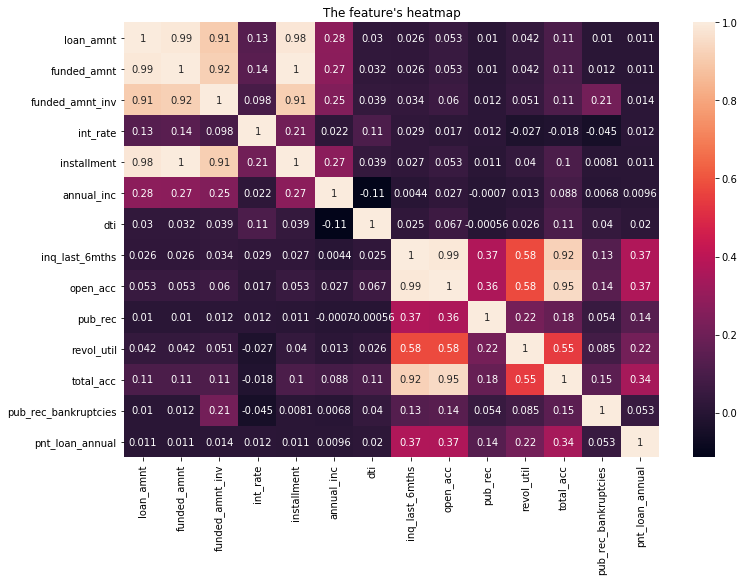

In [23]:
# 3.2 根据相关性与iv筛选特征(连续性特征)
# 注：相关性高的两个特征(阈值0.7)，可删除iv值较小的特征
# 相关性分析：连续性特征(14个)
sub_num_feature = list(df_s[sel_feature_])[3:]
sub_char_feature = list(df_s[sel_feature_])[0:3]
sn_df = df_s[sub_num_feature].corr()
# 热力图
plot_seaborn(sn_df)
numf_vi = feature_sels_vi[3:].reset_index().drop('index', axis=1)

# 可删除特征字段
del_feature_subs = del_feature_sub(sn_df, numf_vi, th_c=0.7)
print('删除特征字段：', len(del_feature_subs), '\n', del_feature_subs)
print('原特征字段：', len(sub_num_feature), '\n', sub_num_feature)
# 新的连续特征字段
new_num_feature = [i for i in sub_num_feature if i not in del_feature_subs]
print('新的特征字段：',len(new_num_feature), '\n', new_num_feature)
# 新的所有特征字段
all_newFeature_sub = sub_char_feature + new_num_feature
print('新的所有特征字段：',len(all_newFeature_sub), '\n', all_newFeature_sub)

In [24]:
# 3.3 根据多重共线性筛选特征(连续型特征)
# 判断：
#    若VIF<3：说明基本不存在多重共线性的问题；
#    若3<VIF<10：存在一定的多重共线性，实情考虑；
#    若VIF>=10：说明问题比较严重，建议删除特征；
vif_df = df_s[new_num_feature]
print(vif_df.shape)
numF_vif = pd.DataFrame()
numF_vif['feature_name'] = vif_df.columns
numF_vif['vif_v'] = [variance_inflation_factor(vif_df.values, i) for i in range(vif_df.shape[1])]
print('最大VIF值：max(vif)=%s\n' % max(numF_vif.vif_v))  # max(vif_v)<10，均无多重共线性，不操作
numF_vif

删除特征字段： 5 
 ['funded_amnt', 'installment', 'open_acc', 'total_acc', 'loan_amnt']
原特征字段： 14 
 ['loan_amnt', 'funded_amnt', 'funded_amnt_inv', 'int_rate', 'installment', 'annual_inc', 'dti', 'inq_last_6mths', 'open_acc', 'pub_rec', 'revol_util', 'total_acc', 'pub_rec_bankruptcies', 'pnt_loan_annual']
新的特征字段： 9 
 ['funded_amnt_inv', 'int_rate', 'annual_inc', 'dti', 'inq_last_6mths', 'pub_rec', 'revol_util', 'pub_rec_bankruptcies', 'pnt_loan_annual']
新的所有特征字段： 12 
 ['emp_length', 'purpose', 'addr_state', 'funded_amnt_inv', 'int_rate', 'annual_inc', 'dti', 'inq_last_6mths', 'pub_rec', 'revol_util', 'pub_rec_bankruptcies', 'pnt_loan_annual']
(31534, 9)
最大VIF值：max(vif)=5.8973037330539



,feature_name,vif_v
0,funded_amnt_inv,3.227471
1,int_rate,5.897304
2,annual_inc,2.171382
3,dti,4.108529
4,inq_last_6mths,1.841611
5,pub_rec,1.158956
6,revol_util,1.515761
7,pub_rec_bankruptcies,1.117218
8,pnt_loan_annual,1.159677


# 4.模型建立与评价

In [84]:
# 数据准备_all_newFeature_sub
df_model = df_s[all_newFeature_sub]
df_model[sub_char_feature] = df_model[sub_char_feature].astype('str')
print(df_model.shape)

# 训练集和测试集划分：7：3
x_train, x_test, y_train, y_test = train_test_split(df_model, df_s['y'], test_size=0.3, random_state=10)
print(x_train.shape)
print(x_test.shape)
print(y_train.shape)
print(y_test.shape)

(31534, 12)
(22073, 12)
(9461, 12)
(22073,)
(9461,)


C:\Users\15742\Anaconda35\lib\site-packages\pandas\core\frame.py:2963: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


In [131]:
# 评价指标
def model_performance(y_train, pre_train, pro_train, y_test, pre_test, pro_test, plot=True):
    # 训练集
    print('Train:')
    fpr0, tpr0, th0 = roc_curve(y_train, pro_train)
    roc_auc0 = auc(fpr0, tpr0)
    print('The model accuracy is {}'.format(accuracy_score(y_train, pre_train)))
    print('The model f1 is {}'.format(f1_score(y_train, pre_train)))
    print('The model p is {}'.format(precision_score(y_train, pre_train)))
    print('The model recall is {}'.format(recall_score(y_train, pre_train)))
    print('The confusion matrix is:\n', confusion_matrix(y_train, pre_train))
    if plot:
        plot_roc_auc(fpr0, tpr0, roc_auc0)
    
    # 测试集
    print('Test:')
    fpr, tpr, th = roc_curve(y_test, pro_test)
    roc_auc = auc(fpr, tpr)
    print('The model accuracy is {}'.format(accuracy_score(y_test, pre_test)))
    print('The model f1 is {}'.format(f1_score(y_test, pre_test)))
    print('The model p is {}'.format(precision_score(y_test, pre_test)))
    print('The model recall is {}'.format(recall_score(y_test, pre_test)))
    print('The model KS is {}'.format(max(tpr - fpr)))
    print('The confusion matrix is:\n', confusion_matrix(y_test, pre_test))
    if plot:
        plot_roc_auc(fpr, tpr, roc_auc)
    return fpr, tpr, roc_auc

def plot_roc_auc(fpr, tpr, roc_auc):
    plt.plot(fpr, tpr, label='AUC = {}'.format(roc_auc))
    plt.title('ROC')
    plt.xlabel('False positive rate')
    plt.ylabel('True positive rate')
    plt.legend()
    plt.plot([0,1],[0,1], c='r')
    plt.show()
    
def get_model_score(pro):
    score = 520 - 48 * np.log(pro/(1-pro))
    score = pd.Series(score).to_frame().rename(columns={0:'score'})
    return score

In [163]:
# ======== 4.1 CatBoost模型 ========

In [101]:
# 网格搜索策略
def get_params_init():
    params_init = {
        'iterations':10,
        'cat_features': [0,1,2],
        'loss_function':'Logloss',
        'depth':5,
        'subsample':0.7,
        'learning_rate':0.1,
        'l2_leaf_reg':0.1,   
    }
    return params_init

def get_tree_params():
    params = {
        'iterations':[10, 50, 100, 150, 200],
        'depth':[5, 6, 7, 8],
    }
    return params

def get_subsample_params():
    params = {
        'subsample':[0.5,0.6,0.7,0.8],
    }
    return params

def get_learn_params():
    params = {
        'learning_rate':[0.01,0.05,0.1,0.15],
    }
    return params

def get_l2_params():
    params = {
        'l2_leaf_reg':[0.1,0.5,1,2],
    }
    return params

def grid_params_model(model, df, label):
    # 参数组合
    grid_params = [get_tree_params(), get_subsample_params(), get_learn_params(), get_l2_params()]
    for _params_ in grid_params:
        
        gcv = GridSearchCV(estimator=model, param_grid=_params_, cv=5, iid=False)
        gcv.fit(df, label)
        print(gcv.scorer_, gcv.best_params_, gcv.best_score_)
        # 参数更新
        gcv_params =  model.get_params()
        gcv_params.update(gcv.best_params_)
        model.set_params(**gcv_params)
        print('the other params!')
    return model
        
def cat_model_run(df, label):
    params_init = get_params_init()
    # 初始模型
    model_cb = cat.CatBoostClassifier(**params_init)
    print(model_cb.get_params())
    model_cb = grid_params_model(model_cb, df, label)
    return model_cb

In [102]:
model_cb = cat_model_run(x_train, y_train)

{'iterations': 10, 'learning_rate': 0.1, 'depth': 5, 'l2_leaf_reg': 0.1, 'loss_function': 'Logloss', 'subsample': 0.7, 'cat_features': [0, 1, 2]}
0:	learn: 0.6390232	total: 21.2ms	remaining: 190ms
1:	learn: 0.5949206	total: 53.1ms	remaining: 212ms
2:	learn: 0.5574641	total: 65.4ms	remaining: 153ms
3:	learn: 0.5265023	total: 101ms	remaining: 152ms
4:	learn: 0.5007500	total: 112ms	remaining: 112ms
5:	learn: 0.4788720	total: 127ms	remaining: 85ms
6:	learn: 0.4605328	total: 160ms	remaining: 68.8ms
7:	learn: 0.4449321	total: 178ms	remaining: 44.5ms
8:	learn: 0.4317451	total: 190ms	remaining: 21.1ms
9:	learn: 0.4202584	total: 201ms	remaining: 0us
0:	learn: 0.6388659	total: 20.6ms	remaining: 186ms
1:	learn: 0.5945650	total: 36.9ms	remaining: 148ms
2:	learn: 0.5576120	total: 50.4ms	remaining: 118ms
3:	learn: 0.5270149	total: 62.1ms	remaining: 93.1ms
4:	learn: 0.5007386	total: 75.6ms	remaining: 75.6ms
5:	learn: 0.4787249	total: 85.9ms	remaining: 57.3ms
6:	learn: 0.4600380	total: 96.4ms	remainin

14:	learn: 0.3835461	total: 209ms	remaining: 487ms
15:	learn: 0.3787227	total: 225ms	remaining: 479ms
16:	learn: 0.3748470	total: 238ms	remaining: 462ms
17:	learn: 0.3714665	total: 249ms	remaining: 442ms
18:	learn: 0.3687638	total: 259ms	remaining: 423ms
19:	learn: 0.3661700	total: 275ms	remaining: 412ms
20:	learn: 0.3637208	total: 285ms	remaining: 394ms
21:	learn: 0.3616614	total: 295ms	remaining: 376ms
22:	learn: 0.3603981	total: 312ms	remaining: 366ms
23:	learn: 0.3589123	total: 322ms	remaining: 349ms
24:	learn: 0.3575956	total: 337ms	remaining: 337ms
25:	learn: 0.3564457	total: 347ms	remaining: 320ms
26:	learn: 0.3553733	total: 365ms	remaining: 311ms
27:	learn: 0.3544676	total: 381ms	remaining: 299ms
28:	learn: 0.3535736	total: 403ms	remaining: 292ms
29:	learn: 0.3525737	total: 419ms	remaining: 279ms
30:	learn: 0.3517166	total: 438ms	remaining: 269ms
31:	learn: 0.3509387	total: 451ms	remaining: 254ms
32:	learn: 0.3499928	total: 468ms	remaining: 241ms
33:	learn: 0.3493379	total: 488

37:	learn: 0.3453438	total: 574ms	remaining: 936ms
38:	learn: 0.3450678	total: 640ms	remaining: 1s
39:	learn: 0.3446247	total: 652ms	remaining: 979ms
40:	learn: 0.3443282	total: 666ms	remaining: 959ms
41:	learn: 0.3438761	total: 682ms	remaining: 941ms
42:	learn: 0.3434213	total: 694ms	remaining: 920ms
43:	learn: 0.3430640	total: 706ms	remaining: 899ms
44:	learn: 0.3427562	total: 717ms	remaining: 876ms
45:	learn: 0.3424038	total: 729ms	remaining: 855ms
46:	learn: 0.3420824	total: 750ms	remaining: 845ms
47:	learn: 0.3419386	total: 760ms	remaining: 823ms
48:	learn: 0.3417696	total: 776ms	remaining: 807ms
49:	learn: 0.3415480	total: 787ms	remaining: 787ms
50:	learn: 0.3412146	total: 804ms	remaining: 772ms
51:	learn: 0.3409485	total: 820ms	remaining: 756ms
52:	learn: 0.3405877	total: 832ms	remaining: 738ms
53:	learn: 0.3403138	total: 870ms	remaining: 741ms
54:	learn: 0.3401205	total: 888ms	remaining: 727ms
55:	learn: 0.3397674	total: 910ms	remaining: 715ms
56:	learn: 0.3394712	total: 927ms	

0:	learn: 0.6384889	total: 17.6ms	remaining: 1.74s
1:	learn: 0.5943068	total: 37.8ms	remaining: 1.85s
2:	learn: 0.5573144	total: 54.6ms	remaining: 1.77s
3:	learn: 0.5271523	total: 66.2ms	remaining: 1.59s
4:	learn: 0.5011560	total: 83.2ms	remaining: 1.58s
5:	learn: 0.4791501	total: 97.9ms	remaining: 1.53s
6:	learn: 0.4606222	total: 117ms	remaining: 1.55s
7:	learn: 0.4447476	total: 130ms	remaining: 1.49s
8:	learn: 0.4319726	total: 140ms	remaining: 1.42s
9:	learn: 0.4203951	total: 154ms	remaining: 1.38s
10:	learn: 0.4105948	total: 176ms	remaining: 1.43s
11:	learn: 0.4022940	total: 269ms	remaining: 1.97s
12:	learn: 0.3950370	total: 313ms	remaining: 2.09s
13:	learn: 0.3886336	total: 328ms	remaining: 2.02s
14:	learn: 0.3835461	total: 341ms	remaining: 1.93s
15:	learn: 0.3787227	total: 353ms	remaining: 1.85s
16:	learn: 0.3748470	total: 372ms	remaining: 1.81s
17:	learn: 0.3714665	total: 386ms	remaining: 1.76s
18:	learn: 0.3687638	total: 399ms	remaining: 1.7s
19:	learn: 0.3661700	total: 413ms	re

72:	learn: 0.3369499	total: 1.08s	remaining: 399ms
73:	learn: 0.3368296	total: 1.09s	remaining: 384ms
74:	learn: 0.3367165	total: 1.1s	remaining: 368ms
75:	learn: 0.3366438	total: 1.11s	remaining: 352ms
76:	learn: 0.3364742	total: 1.12s	remaining: 336ms
77:	learn: 0.3362819	total: 1.13s	remaining: 320ms
78:	learn: 0.3361067	total: 1.15s	remaining: 305ms
79:	learn: 0.3359910	total: 1.16s	remaining: 290ms
80:	learn: 0.3357795	total: 1.17s	remaining: 275ms
81:	learn: 0.3356311	total: 1.18s	remaining: 259ms
82:	learn: 0.3355329	total: 1.19s	remaining: 244ms
83:	learn: 0.3353603	total: 1.2s	remaining: 229ms
84:	learn: 0.3351667	total: 1.22s	remaining: 214ms
85:	learn: 0.3350143	total: 1.23s	remaining: 200ms
86:	learn: 0.3348332	total: 1.24s	remaining: 185ms
87:	learn: 0.3347062	total: 1.25s	remaining: 170ms
88:	learn: 0.3345351	total: 1.26s	remaining: 156ms
89:	learn: 0.3342938	total: 1.27s	remaining: 141ms
90:	learn: 0.3340700	total: 1.29s	remaining: 127ms
91:	learn: 0.3338583	total: 1.3s	

43:	learn: 0.3430640	total: 545ms	remaining: 1.31s
44:	learn: 0.3427562	total: 559ms	remaining: 1.3s
45:	learn: 0.3424038	total: 572ms	remaining: 1.29s
46:	learn: 0.3420824	total: 587ms	remaining: 1.29s
47:	learn: 0.3419386	total: 597ms	remaining: 1.27s
48:	learn: 0.3417696	total: 607ms	remaining: 1.25s
49:	learn: 0.3415480	total: 619ms	remaining: 1.24s
50:	learn: 0.3412146	total: 633ms	remaining: 1.23s
51:	learn: 0.3409485	total: 644ms	remaining: 1.21s
52:	learn: 0.3405877	total: 659ms	remaining: 1.21s
53:	learn: 0.3403138	total: 673ms	remaining: 1.2s
54:	learn: 0.3401205	total: 689ms	remaining: 1.19s
55:	learn: 0.3397674	total: 702ms	remaining: 1.18s
56:	learn: 0.3394712	total: 714ms	remaining: 1.17s
57:	learn: 0.3393640	total: 725ms	remaining: 1.15s
58:	learn: 0.3390668	total: 735ms	remaining: 1.13s
59:	learn: 0.3390354	total: 746ms	remaining: 1.12s
60:	learn: 0.3388198	total: 761ms	remaining: 1.11s
61:	learn: 0.3386622	total: 774ms	remaining: 1.1s
62:	learn: 0.3384873	total: 788ms	

60:	learn: 0.3386799	total: 737ms	remaining: 1.07s
61:	learn: 0.3384820	total: 748ms	remaining: 1.06s
62:	learn: 0.3382659	total: 762ms	remaining: 1.05s
63:	learn: 0.3380506	total: 774ms	remaining: 1.04s
64:	learn: 0.3378162	total: 787ms	remaining: 1.03s
65:	learn: 0.3375352	total: 799ms	remaining: 1.02s
66:	learn: 0.3373428	total: 809ms	remaining: 1s
67:	learn: 0.3371341	total: 822ms	remaining: 991ms
68:	learn: 0.3368808	total: 833ms	remaining: 977ms
69:	learn: 0.3366279	total: 843ms	remaining: 964ms
70:	learn: 0.3365130	total: 853ms	remaining: 949ms
71:	learn: 0.3362753	total: 865ms	remaining: 937ms
72:	learn: 0.3362055	total: 874ms	remaining: 922ms
73:	learn: 0.3359848	total: 886ms	remaining: 910ms
74:	learn: 0.3357429	total: 898ms	remaining: 898ms
75:	learn: 0.3355698	total: 910ms	remaining: 886ms
76:	learn: 0.3353974	total: 922ms	remaining: 874ms
77:	learn: 0.3352007	total: 934ms	remaining: 862ms
78:	learn: 0.3350810	total: 945ms	remaining: 850ms
79:	learn: 0.3348793	total: 957ms	

80:	learn: 0.3364503	total: 1.1s	remaining: 940ms
81:	learn: 0.3363238	total: 1.13s	remaining: 939ms
82:	learn: 0.3361443	total: 1.15s	remaining: 928ms
83:	learn: 0.3359408	total: 1.2s	remaining: 942ms
84:	learn: 0.3357551	total: 1.22s	remaining: 935ms
85:	learn: 0.3355514	total: 1.24s	remaining: 925ms
86:	learn: 0.3353278	total: 1.28s	remaining: 930ms
87:	learn: 0.3351294	total: 1.32s	remaining: 932ms
88:	learn: 0.3348197	total: 1.37s	remaining: 940ms
89:	learn: 0.3346615	total: 1.39s	remaining: 926ms
90:	learn: 0.3344304	total: 1.41s	remaining: 913ms
91:	learn: 0.3341335	total: 1.42s	remaining: 897ms
92:	learn: 0.3339876	total: 1.44s	remaining: 881ms
93:	learn: 0.3338319	total: 1.45s	remaining: 867ms
94:	learn: 0.3337128	total: 1.47s	remaining: 851ms
95:	learn: 0.3335159	total: 1.5s	remaining: 846ms
96:	learn: 0.3333567	total: 1.51s	remaining: 828ms
97:	learn: 0.3332542	total: 1.53s	remaining: 810ms
98:	learn: 0.3329582	total: 1.54s	remaining: 793ms
99:	learn: 0.3328173	total: 1.55s	

91:	learn: 0.3338583	total: 1.28s	remaining: 806ms
92:	learn: 0.3336062	total: 1.29s	remaining: 792ms
93:	learn: 0.3335086	total: 1.31s	remaining: 781ms
94:	learn: 0.3333434	total: 1.32s	remaining: 766ms
95:	learn: 0.3331552	total: 1.33s	remaining: 750ms
96:	learn: 0.3330040	total: 1.34s	remaining: 735ms
97:	learn: 0.3328483	total: 1.35s	remaining: 719ms
98:	learn: 0.3326188	total: 1.37s	remaining: 704ms
99:	learn: 0.3323791	total: 1.38s	remaining: 690ms
100:	learn: 0.3322356	total: 1.39s	remaining: 675ms
101:	learn: 0.3320553	total: 1.41s	remaining: 661ms
102:	learn: 0.3318998	total: 1.42s	remaining: 646ms
103:	learn: 0.3317356	total: 1.43s	remaining: 633ms
104:	learn: 0.3314791	total: 1.45s	remaining: 620ms
105:	learn: 0.3311718	total: 1.46s	remaining: 606ms
106:	learn: 0.3309784	total: 1.47s	remaining: 591ms
107:	learn: 0.3308933	total: 1.49s	remaining: 578ms
108:	learn: 0.3306714	total: 1.5s	remaining: 566ms
109:	learn: 0.3304622	total: 1.52s	remaining: 554ms
110:	learn: 0.3301381	

112:	learn: 0.3285447	total: 1.43s	remaining: 469ms
113:	learn: 0.3283559	total: 1.45s	remaining: 457ms
114:	learn: 0.3282743	total: 1.46s	remaining: 444ms
115:	learn: 0.3280862	total: 1.47s	remaining: 431ms
116:	learn: 0.3279228	total: 1.48s	remaining: 418ms
117:	learn: 0.3276902	total: 1.49s	remaining: 405ms
118:	learn: 0.3275056	total: 1.5s	remaining: 392ms
119:	learn: 0.3272870	total: 1.51s	remaining: 379ms
120:	learn: 0.3269810	total: 1.52s	remaining: 365ms
121:	learn: 0.3268945	total: 1.54s	remaining: 353ms
122:	learn: 0.3267178	total: 1.55s	remaining: 340ms
123:	learn: 0.3264857	total: 1.56s	remaining: 327ms
124:	learn: 0.3262285	total: 1.57s	remaining: 313ms
125:	learn: 0.3260344	total: 1.58s	remaining: 300ms
126:	learn: 0.3258503	total: 1.59s	remaining: 288ms
127:	learn: 0.3255746	total: 1.6s	remaining: 275ms
128:	learn: 0.3253463	total: 1.62s	remaining: 263ms
129:	learn: 0.3251428	total: 1.63s	remaining: 251ms
130:	learn: 0.3250037	total: 1.64s	remaining: 239ms
131:	learn: 0.

127:	learn: 0.3219423	total: 4.61s	remaining: 2.59s
128:	learn: 0.3216866	total: 4.65s	remaining: 2.56s
129:	learn: 0.3215976	total: 4.68s	remaining: 2.52s
130:	learn: 0.3213893	total: 4.71s	remaining: 2.48s
131:	learn: 0.3211578	total: 4.74s	remaining: 2.44s
132:	learn: 0.3209367	total: 4.78s	remaining: 2.41s
133:	learn: 0.3207988	total: 4.8s	remaining: 2.37s
134:	learn: 0.3206235	total: 4.84s	remaining: 2.33s
135:	learn: 0.3205063	total: 4.88s	remaining: 2.29s
136:	learn: 0.3203613	total: 4.92s	remaining: 2.26s
137:	learn: 0.3201190	total: 4.96s	remaining: 2.23s
138:	learn: 0.3199227	total: 5s	remaining: 2.19s
139:	learn: 0.3197454	total: 5.03s	remaining: 2.16s
140:	learn: 0.3196486	total: 5.07s	remaining: 2.12s
141:	learn: 0.3195063	total: 5.11s	remaining: 2.09s
142:	learn: 0.3192083	total: 5.14s	remaining: 2.05s
143:	learn: 0.3188918	total: 5.19s	remaining: 2.02s
144:	learn: 0.3188406	total: 5.22s	remaining: 1.98s
145:	learn: 0.3186689	total: 5.26s	remaining: 1.95s
146:	learn: 0.31

90:	learn: 0.3297931	total: 3.28s	remaining: 3.93s
91:	learn: 0.3295868	total: 3.32s	remaining: 3.9s
92:	learn: 0.3292799	total: 3.36s	remaining: 3.86s
93:	learn: 0.3290263	total: 3.4s	remaining: 3.83s
94:	learn: 0.3287303	total: 3.43s	remaining: 3.79s
95:	learn: 0.3284224	total: 3.48s	remaining: 3.77s
96:	learn: 0.3281923	total: 3.52s	remaining: 3.74s
97:	learn: 0.3280416	total: 3.56s	remaining: 3.71s
98:	learn: 0.3277761	total: 3.6s	remaining: 3.67s
99:	learn: 0.3275981	total: 3.63s	remaining: 3.63s
100:	learn: 0.3272868	total: 3.67s	remaining: 3.6s
101:	learn: 0.3270364	total: 3.71s	remaining: 3.56s
102:	learn: 0.3267450	total: 3.74s	remaining: 3.52s
103:	learn: 0.3265432	total: 3.78s	remaining: 3.49s
104:	learn: 0.3263126	total: 3.82s	remaining: 3.45s
105:	learn: 0.3260094	total: 3.86s	remaining: 3.42s
106:	learn: 0.3257669	total: 3.89s	remaining: 3.38s
107:	learn: 0.3255061	total: 3.93s	remaining: 3.35s
108:	learn: 0.3251960	total: 3.95s	remaining: 3.3s
109:	learn: 0.3248556	total

50:	learn: 0.3401873	total: 1.79s	remaining: 5.24s
51:	learn: 0.3399436	total: 1.82s	remaining: 5.2s
52:	learn: 0.3395444	total: 1.86s	remaining: 5.17s
53:	learn: 0.3391807	total: 1.9s	remaining: 5.14s
54:	learn: 0.3388770	total: 1.94s	remaining: 5.1s
55:	learn: 0.3384835	total: 1.97s	remaining: 5.08s
56:	learn: 0.3383156	total: 2s	remaining: 5.03s
57:	learn: 0.3381211	total: 2.04s	remaining: 4.99s
58:	learn: 0.3378512	total: 2.08s	remaining: 4.98s
59:	learn: 0.3376650	total: 2.12s	remaining: 4.95s
60:	learn: 0.3374999	total: 2.16s	remaining: 4.92s
61:	learn: 0.3373588	total: 2.21s	remaining: 4.92s
62:	learn: 0.3370830	total: 2.25s	remaining: 4.89s
63:	learn: 0.3368361	total: 2.29s	remaining: 4.87s
64:	learn: 0.3365432	total: 2.33s	remaining: 4.84s
65:	learn: 0.3364104	total: 2.37s	remaining: 4.81s
66:	learn: 0.3363583	total: 2.4s	remaining: 4.76s
67:	learn: 0.3360357	total: 2.44s	remaining: 4.73s
68:	learn: 0.3357539	total: 2.47s	remaining: 4.7s
69:	learn: 0.3355859	total: 2.51s	remai

10:	learn: 0.3825885	total: 462ms	remaining: 7.94s
11:	learn: 0.3766093	total: 505ms	remaining: 7.92s
12:	learn: 0.3718609	total: 545ms	remaining: 7.84s
13:	learn: 0.3675148	total: 591ms	remaining: 7.85s
14:	learn: 0.3641744	total: 634ms	remaining: 7.81s
15:	learn: 0.3610725	total: 683ms	remaining: 7.85s
16:	learn: 0.3595723	total: 702ms	remaining: 7.55s
17:	learn: 0.3576475	total: 722ms	remaining: 7.3s
18:	learn: 0.3555879	total: 764ms	remaining: 7.28s
19:	learn: 0.3542746	total: 802ms	remaining: 7.21s
20:	learn: 0.3527551	total: 848ms	remaining: 7.22s
21:	learn: 0.3515499	total: 895ms	remaining: 7.24s
22:	learn: 0.3504066	total: 933ms	remaining: 7.18s
23:	learn: 0.3492728	total: 985ms	remaining: 7.23s
24:	learn: 0.3483670	total: 1.03s	remaining: 7.23s
25:	learn: 0.3474594	total: 1.09s	remaining: 7.29s
26:	learn: 0.3472666	total: 1.11s	remaining: 7.1s
27:	learn: 0.3466754	total: 1.14s	remaining: 7.03s
28:	learn: 0.3459943	total: 1.17s	remaining: 6.9s
29:	learn: 0.3454890	total: 1.21s	

174:	learn: 0.3135847	total: 6.61s	remaining: 944ms
175:	learn: 0.3134304	total: 6.65s	remaining: 907ms
176:	learn: 0.3131656	total: 6.68s	remaining: 869ms
177:	learn: 0.3128416	total: 6.74s	remaining: 832ms
178:	learn: 0.3127510	total: 6.77s	remaining: 794ms
179:	learn: 0.3124955	total: 6.8s	remaining: 756ms
180:	learn: 0.3121998	total: 6.85s	remaining: 719ms
181:	learn: 0.3121515	total: 6.88s	remaining: 680ms
182:	learn: 0.3119727	total: 6.91s	remaining: 641ms
183:	learn: 0.3118755	total: 6.94s	remaining: 604ms
184:	learn: 0.3117144	total: 6.97s	remaining: 566ms
185:	learn: 0.3115115	total: 7.02s	remaining: 529ms
186:	learn: 0.3112888	total: 7.06s	remaining: 491ms
187:	learn: 0.3111027	total: 7.09s	remaining: 453ms
188:	learn: 0.3110210	total: 7.13s	remaining: 415ms
189:	learn: 0.3108902	total: 7.16s	remaining: 377ms
190:	learn: 0.3108231	total: 7.2s	remaining: 339ms
191:	learn: 0.3107138	total: 7.24s	remaining: 302ms
192:	learn: 0.3104641	total: 7.28s	remaining: 264ms
193:	learn: 0.

135:	learn: 0.3200191	total: 5.59s	remaining: 2.63s
136:	learn: 0.3198093	total: 5.62s	remaining: 2.59s
137:	learn: 0.3196491	total: 5.67s	remaining: 2.55s
138:	learn: 0.3193798	total: 5.73s	remaining: 2.51s
139:	learn: 0.3192188	total: 5.77s	remaining: 2.47s
140:	learn: 0.3188603	total: 5.8s	remaining: 2.43s
141:	learn: 0.3185875	total: 5.84s	remaining: 2.38s
142:	learn: 0.3183851	total: 5.87s	remaining: 2.34s
143:	learn: 0.3182720	total: 5.91s	remaining: 2.3s
144:	learn: 0.3179515	total: 5.96s	remaining: 2.26s
145:	learn: 0.3177281	total: 6.01s	remaining: 2.22s
146:	learn: 0.3174305	total: 6.05s	remaining: 2.18s
147:	learn: 0.3171493	total: 6.09s	remaining: 2.14s
148:	learn: 0.3168588	total: 6.13s	remaining: 2.1s
149:	learn: 0.3166239	total: 6.22s	remaining: 2.07s
150:	learn: 0.3165016	total: 6.32s	remaining: 2.05s
151:	learn: 0.3163429	total: 6.39s	remaining: 2.02s
152:	learn: 0.3161400	total: 6.43s	remaining: 1.97s
153:	learn: 0.3159796	total: 6.46s	remaining: 1.93s
154:	learn: 0.3

0:	learn: 0.6388510	total: 17.3ms	remaining: 847ms
1:	learn: 0.5939090	total: 34.9ms	remaining: 838ms
2:	learn: 0.5567583	total: 50.4ms	remaining: 789ms
3:	learn: 0.5255251	total: 65.7ms	remaining: 756ms
4:	learn: 0.4996084	total: 79.8ms	remaining: 718ms
5:	learn: 0.4777872	total: 91.5ms	remaining: 671ms
6:	learn: 0.4587019	total: 105ms	remaining: 643ms
7:	learn: 0.4431372	total: 119ms	remaining: 624ms
8:	learn: 0.4295756	total: 132ms	remaining: 601ms
9:	learn: 0.4183222	total: 144ms	remaining: 576ms
10:	learn: 0.4087400	total: 158ms	remaining: 561ms
11:	learn: 0.4005320	total: 170ms	remaining: 540ms
12:	learn: 0.3933230	total: 185ms	remaining: 526ms
13:	learn: 0.3870925	total: 204ms	remaining: 525ms
14:	learn: 0.3817199	total: 219ms	remaining: 510ms
15:	learn: 0.3773406	total: 234ms	remaining: 497ms
16:	learn: 0.3734138	total: 247ms	remaining: 480ms
17:	learn: 0.3697429	total: 261ms	remaining: 463ms
18:	learn: 0.3668402	total: 275ms	remaining: 448ms
19:	learn: 0.3642045	total: 288ms	r

13:	learn: 0.3868898	total: 214ms	remaining: 550ms
14:	learn: 0.3815099	total: 228ms	remaining: 532ms
15:	learn: 0.3772121	total: 242ms	remaining: 514ms
16:	learn: 0.3731364	total: 255ms	remaining: 495ms
17:	learn: 0.3695778	total: 271ms	remaining: 482ms
18:	learn: 0.3666217	total: 286ms	remaining: 467ms
19:	learn: 0.3640146	total: 302ms	remaining: 454ms
20:	learn: 0.3614913	total: 318ms	remaining: 439ms
21:	learn: 0.3601422	total: 329ms	remaining: 419ms
22:	learn: 0.3585113	total: 341ms	remaining: 400ms
23:	learn: 0.3564649	total: 354ms	remaining: 384ms
24:	learn: 0.3548808	total: 368ms	remaining: 368ms
25:	learn: 0.3533702	total: 384ms	remaining: 354ms
26:	learn: 0.3519655	total: 401ms	remaining: 341ms
27:	learn: 0.3505556	total: 416ms	remaining: 327ms
28:	learn: 0.3494997	total: 431ms	remaining: 312ms
29:	learn: 0.3487126	total: 447ms	remaining: 298ms
30:	learn: 0.3476512	total: 461ms	remaining: 283ms
31:	learn: 0.3467060	total: 476ms	remaining: 268ms
32:	learn: 0.3459277	total: 490

26:	learn: 0.3529902	total: 392ms	remaining: 1.06s
27:	learn: 0.3519263	total: 404ms	remaining: 1.04s
28:	learn: 0.3509667	total: 418ms	remaining: 1.02s
29:	learn: 0.3500424	total: 431ms	remaining: 1.01s
30:	learn: 0.3489318	total: 447ms	remaining: 995ms
31:	learn: 0.3478619	total: 461ms	remaining: 981ms
32:	learn: 0.3467783	total: 475ms	remaining: 965ms
33:	learn: 0.3459882	total: 489ms	remaining: 949ms
34:	learn: 0.3453748	total: 503ms	remaining: 934ms
35:	learn: 0.3445070	total: 520ms	remaining: 924ms
36:	learn: 0.3438876	total: 534ms	remaining: 910ms
37:	learn: 0.3431621	total: 549ms	remaining: 897ms
38:	learn: 0.3430691	total: 558ms	remaining: 873ms
39:	learn: 0.3425158	total: 570ms	remaining: 854ms
40:	learn: 0.3420423	total: 587ms	remaining: 844ms
41:	learn: 0.3413132	total: 603ms	remaining: 833ms
42:	learn: 0.3407035	total: 616ms	remaining: 816ms
43:	learn: 0.3403316	total: 629ms	remaining: 801ms
44:	learn: 0.3399429	total: 643ms	remaining: 786ms
45:	learn: 0.3392496	total: 658

88:	learn: 0.3289699	total: 1.28s	remaining: 159ms
89:	learn: 0.3286993	total: 1.3s	remaining: 144ms
90:	learn: 0.3284781	total: 1.31s	remaining: 130ms
91:	learn: 0.3280990	total: 1.33s	remaining: 115ms
92:	learn: 0.3278321	total: 1.34s	remaining: 101ms
93:	learn: 0.3276750	total: 1.35s	remaining: 86.5ms
94:	learn: 0.3274755	total: 1.37s	remaining: 72.1ms
95:	learn: 0.3273228	total: 1.38s	remaining: 57.6ms
96:	learn: 0.3269527	total: 1.4s	remaining: 43.2ms
97:	learn: 0.3265981	total: 1.41s	remaining: 28.9ms
98:	learn: 0.3263912	total: 1.43s	remaining: 14.4ms
99:	learn: 0.3261282	total: 1.44s	remaining: 0us
0:	learn: 0.6384234	total: 18.2ms	remaining: 1.81s
1:	learn: 0.5935159	total: 32.3ms	remaining: 1.58s
2:	learn: 0.5564758	total: 46.1ms	remaining: 1.49s
3:	learn: 0.5252868	total: 61.6ms	remaining: 1.48s
4:	learn: 0.4993178	total: 74.7ms	remaining: 1.42s
5:	learn: 0.4773583	total: 89.6ms	remaining: 1.4s
6:	learn: 0.4584089	total: 104ms	remaining: 1.38s
7:	learn: 0.4430866	total: 118m

50:	learn: 0.3363136	total: 743ms	remaining: 714ms
51:	learn: 0.3359667	total: 759ms	remaining: 701ms
52:	learn: 0.3355311	total: 777ms	remaining: 689ms
53:	learn: 0.3352372	total: 789ms	remaining: 672ms
54:	learn: 0.3349979	total: 803ms	remaining: 657ms
55:	learn: 0.3347528	total: 816ms	remaining: 641ms
56:	learn: 0.3342931	total: 831ms	remaining: 627ms
57:	learn: 0.3340357	total: 844ms	remaining: 611ms
58:	learn: 0.3337427	total: 858ms	remaining: 596ms
59:	learn: 0.3335611	total: 875ms	remaining: 583ms
60:	learn: 0.3332440	total: 888ms	remaining: 568ms
61:	learn: 0.3329344	total: 903ms	remaining: 553ms
62:	learn: 0.3326712	total: 916ms	remaining: 538ms
63:	learn: 0.3324600	total: 934ms	remaining: 525ms
64:	learn: 0.3320908	total: 947ms	remaining: 510ms
65:	learn: 0.3318364	total: 962ms	remaining: 495ms
66:	learn: 0.3315774	total: 975ms	remaining: 480ms
67:	learn: 0.3312855	total: 989ms	remaining: 465ms
68:	learn: 0.3309844	total: 1s	remaining: 450ms
69:	learn: 0.3308500	total: 1.02s	

114:	learn: 0.3198054	total: 1.84s	remaining: 561ms
115:	learn: 0.3195555	total: 1.86s	remaining: 546ms
116:	learn: 0.3192208	total: 1.88s	remaining: 530ms
117:	learn: 0.3188232	total: 1.89s	remaining: 513ms
118:	learn: 0.3185115	total: 1.91s	remaining: 497ms
119:	learn: 0.3182757	total: 1.92s	remaining: 481ms
120:	learn: 0.3179769	total: 1.94s	remaining: 464ms
121:	learn: 0.3177021	total: 1.95s	remaining: 447ms
122:	learn: 0.3174917	total: 1.96s	remaining: 431ms
123:	learn: 0.3172521	total: 1.98s	remaining: 415ms
124:	learn: 0.3169272	total: 1.99s	remaining: 398ms
125:	learn: 0.3164716	total: 2.01s	remaining: 382ms
126:	learn: 0.3161402	total: 2.02s	remaining: 366ms
127:	learn: 0.3159263	total: 2.04s	remaining: 350ms
128:	learn: 0.3155812	total: 2.05s	remaining: 334ms
129:	learn: 0.3152580	total: 2.06s	remaining: 318ms
130:	learn: 0.3149121	total: 2.08s	remaining: 301ms
131:	learn: 0.3147296	total: 2.09s	remaining: 285ms
132:	learn: 0.3144622	total: 2.11s	remaining: 269ms
133:	learn: 

124:	learn: 0.3181664	total: 1.86s	remaining: 373ms
125:	learn: 0.3178568	total: 1.88s	remaining: 358ms
126:	learn: 0.3175589	total: 1.89s	remaining: 343ms
127:	learn: 0.3173824	total: 1.91s	remaining: 327ms
128:	learn: 0.3172406	total: 1.92s	remaining: 312ms
129:	learn: 0.3168660	total: 1.93s	remaining: 297ms
130:	learn: 0.3166177	total: 1.95s	remaining: 283ms
131:	learn: 0.3164266	total: 1.96s	remaining: 268ms
132:	learn: 0.3161946	total: 1.98s	remaining: 253ms
133:	learn: 0.3159731	total: 1.99s	remaining: 238ms
134:	learn: 0.3156361	total: 2s	remaining: 223ms
135:	learn: 0.3153327	total: 2.02s	remaining: 208ms
136:	learn: 0.3152016	total: 2.03s	remaining: 193ms
137:	learn: 0.3148712	total: 2.05s	remaining: 178ms
138:	learn: 0.3144597	total: 2.06s	remaining: 163ms
139:	learn: 0.3142213	total: 2.08s	remaining: 149ms
140:	learn: 0.3138284	total: 2.1s	remaining: 134ms
141:	learn: 0.3136407	total: 2.11s	remaining: 119ms
142:	learn: 0.3135111	total: 2.13s	remaining: 104ms
143:	learn: 0.31

136:	learn: 0.3163143	total: 1.99s	remaining: 188ms
137:	learn: 0.3160197	total: 2s	remaining: 174ms
138:	learn: 0.3155593	total: 2.02s	remaining: 160ms
139:	learn: 0.3151237	total: 2.03s	remaining: 145ms
140:	learn: 0.3149137	total: 2.05s	remaining: 131ms
141:	learn: 0.3145243	total: 2.06s	remaining: 116ms
142:	learn: 0.3141459	total: 2.07s	remaining: 101ms
143:	learn: 0.3138169	total: 2.09s	remaining: 86.9ms
144:	learn: 0.3135327	total: 2.1s	remaining: 72.5ms
145:	learn: 0.3132539	total: 2.12s	remaining: 58ms
146:	learn: 0.3130098	total: 2.13s	remaining: 43.5ms
147:	learn: 0.3126363	total: 2.14s	remaining: 29ms
148:	learn: 0.3123211	total: 2.16s	remaining: 14.5ms
149:	learn: 0.3120722	total: 2.18s	remaining: 0us
0:	learn: 0.6384234	total: 15.5ms	remaining: 2.31s
1:	learn: 0.5935159	total: 30.7ms	remaining: 2.27s
2:	learn: 0.5564758	total: 46.1ms	remaining: 2.26s
3:	learn: 0.5252868	total: 62.1ms	remaining: 2.27s
4:	learn: 0.4993178	total: 78.4ms	remaining: 2.27s
5:	learn: 0.4773583	t

0:	learn: 0.6384151	total: 17.2ms	remaining: 2.56s
1:	learn: 0.5935139	total: 29.3ms	remaining: 2.17s
2:	learn: 0.5564833	total: 42.5ms	remaining: 2.08s
3:	learn: 0.5253410	total: 59.1ms	remaining: 2.16s
4:	learn: 0.4992331	total: 73.5ms	remaining: 2.13s
5:	learn: 0.4773701	total: 90.3ms	remaining: 2.17s
6:	learn: 0.4584145	total: 104ms	remaining: 2.13s
7:	learn: 0.4431182	total: 118ms	remaining: 2.1s
8:	learn: 0.4296892	total: 136ms	remaining: 2.13s
9:	learn: 0.4184792	total: 151ms	remaining: 2.12s
10:	learn: 0.4086937	total: 163ms	remaining: 2.06s
11:	learn: 0.4002980	total: 178ms	remaining: 2.04s
12:	learn: 0.3931029	total: 190ms	remaining: 2.01s
13:	learn: 0.3868898	total: 207ms	remaining: 2.01s
14:	learn: 0.3815099	total: 222ms	remaining: 1.99s
15:	learn: 0.3772121	total: 239ms	remaining: 2s
16:	learn: 0.3731364	total: 253ms	remaining: 1.98s
17:	learn: 0.3695778	total: 266ms	remaining: 1.95s
18:	learn: 0.3666217	total: 278ms	remaining: 1.91s
19:	learn: 0.3640146	total: 291ms	remai

14:	learn: 0.3604671	total: 662ms	remaining: 8.16s
15:	learn: 0.3578447	total: 704ms	remaining: 8.09s
16:	learn: 0.3565958	total: 716ms	remaining: 7.7s
17:	learn: 0.3545904	total: 758ms	remaining: 7.66s
18:	learn: 0.3527812	total: 794ms	remaining: 7.57s
19:	learn: 0.3514928	total: 839ms	remaining: 7.55s
20:	learn: 0.3498514	total: 890ms	remaining: 7.59s
21:	learn: 0.3482613	total: 934ms	remaining: 7.56s
22:	learn: 0.3468740	total: 974ms	remaining: 7.49s
23:	learn: 0.3464247	total: 1.01s	remaining: 7.42s
24:	learn: 0.3460626	total: 1.03s	remaining: 7.24s
25:	learn: 0.3451865	total: 1.07s	remaining: 7.19s
26:	learn: 0.3444791	total: 1.12s	remaining: 7.18s
27:	learn: 0.3437441	total: 1.16s	remaining: 7.11s
28:	learn: 0.3430009	total: 1.2s	remaining: 7.07s
29:	learn: 0.3424552	total: 1.23s	remaining: 7s
30:	learn: 0.3418921	total: 1.28s	remaining: 6.99s
31:	learn: 0.3411268	total: 1.31s	remaining: 6.91s
32:	learn: 0.3405266	total: 1.36s	remaining: 6.89s
33:	learn: 0.3398105	total: 1.41s	re

175:	learn: 0.2928345	total: 7.59s	remaining: 1.03s
176:	learn: 0.2924179	total: 7.64s	remaining: 992ms
177:	learn: 0.2923215	total: 7.67s	remaining: 949ms
178:	learn: 0.2921189	total: 7.71s	remaining: 905ms
179:	learn: 0.2918461	total: 7.76s	remaining: 863ms
180:	learn: 0.2915440	total: 7.81s	remaining: 820ms
181:	learn: 0.2911044	total: 7.86s	remaining: 777ms
182:	learn: 0.2909024	total: 7.9s	remaining: 734ms
183:	learn: 0.2906098	total: 7.94s	remaining: 690ms
184:	learn: 0.2901774	total: 7.99s	remaining: 648ms
185:	learn: 0.2900684	total: 8.03s	remaining: 605ms
186:	learn: 0.2898818	total: 8.07s	remaining: 561ms
187:	learn: 0.2896012	total: 8.12s	remaining: 518ms
188:	learn: 0.2893999	total: 8.16s	remaining: 475ms
189:	learn: 0.2892720	total: 8.21s	remaining: 432ms
190:	learn: 0.2891107	total: 8.25s	remaining: 389ms
191:	learn: 0.2887722	total: 8.31s	remaining: 346ms
192:	learn: 0.2883349	total: 8.35s	remaining: 303ms
193:	learn: 0.2879830	total: 8.4s	remaining: 260ms
194:	learn: 0.

137:	learn: 0.3051044	total: 5.93s	remaining: 2.67s
138:	learn: 0.3047002	total: 5.98s	remaining: 2.63s
139:	learn: 0.3044650	total: 6.02s	remaining: 2.58s
140:	learn: 0.3040893	total: 6.07s	remaining: 2.54s
141:	learn: 0.3037920	total: 6.1s	remaining: 2.49s
142:	learn: 0.3032187	total: 6.14s	remaining: 2.45s
143:	learn: 0.3029894	total: 6.19s	remaining: 2.41s
144:	learn: 0.3024362	total: 6.24s	remaining: 2.37s
145:	learn: 0.3021843	total: 6.28s	remaining: 2.32s
146:	learn: 0.3019041	total: 6.33s	remaining: 2.28s
147:	learn: 0.3016026	total: 6.38s	remaining: 2.24s
148:	learn: 0.3012975	total: 6.43s	remaining: 2.2s
149:	learn: 0.3009845	total: 6.48s	remaining: 2.16s
150:	learn: 0.3005919	total: 6.52s	remaining: 2.12s
151:	learn: 0.3004654	total: 6.57s	remaining: 2.07s
152:	learn: 0.3000707	total: 6.62s	remaining: 2.03s
153:	learn: 0.2999075	total: 6.66s	remaining: 1.99s
154:	learn: 0.2996749	total: 6.7s	remaining: 1.94s
155:	learn: 0.2993357	total: 6.75s	remaining: 1.9s
156:	learn: 0.29

102:	learn: 0.3169109	total: 4.51s	remaining: 4.25s
103:	learn: 0.3168117	total: 4.55s	remaining: 4.2s
104:	learn: 0.3164678	total: 4.59s	remaining: 4.15s
105:	learn: 0.3161398	total: 4.63s	remaining: 4.11s
106:	learn: 0.3159383	total: 4.67s	remaining: 4.06s
107:	learn: 0.3154406	total: 4.72s	remaining: 4.02s
108:	learn: 0.3149887	total: 4.76s	remaining: 3.98s
109:	learn: 0.3146459	total: 4.81s	remaining: 3.93s
110:	learn: 0.3143626	total: 4.85s	remaining: 3.89s
111:	learn: 0.3140237	total: 4.89s	remaining: 3.84s
112:	learn: 0.3133503	total: 4.94s	remaining: 3.8s
113:	learn: 0.3129528	total: 4.98s	remaining: 3.76s
114:	learn: 0.3125664	total: 5.03s	remaining: 3.72s
115:	learn: 0.3123188	total: 5.07s	remaining: 3.67s
116:	learn: 0.3119573	total: 5.12s	remaining: 3.63s
117:	learn: 0.3117064	total: 5.16s	remaining: 3.59s
118:	learn: 0.3115785	total: 5.21s	remaining: 3.54s
119:	learn: 0.3111430	total: 5.25s	remaining: 3.5s
120:	learn: 0.3108287	total: 5.3s	remaining: 3.46s
121:	learn: 0.31

64:	learn: 0.3276607	total: 3.06s	remaining: 6.36s
65:	learn: 0.3273771	total: 3.11s	remaining: 6.32s
66:	learn: 0.3271155	total: 3.16s	remaining: 6.27s
67:	learn: 0.3270281	total: 3.21s	remaining: 6.22s
68:	learn: 0.3266035	total: 3.25s	remaining: 6.16s
69:	learn: 0.3262824	total: 3.31s	remaining: 6.14s
70:	learn: 0.3260604	total: 3.36s	remaining: 6.1s
71:	learn: 0.3258335	total: 3.41s	remaining: 6.06s
72:	learn: 0.3254346	total: 3.45s	remaining: 6s
73:	learn: 0.3252680	total: 3.5s	remaining: 5.96s
74:	learn: 0.3251566	total: 3.53s	remaining: 5.88s
75:	learn: 0.3248134	total: 3.57s	remaining: 5.83s
76:	learn: 0.3246149	total: 3.62s	remaining: 5.78s
77:	learn: 0.3242463	total: 3.67s	remaining: 5.74s
78:	learn: 0.3239778	total: 3.72s	remaining: 5.7s
79:	learn: 0.3235011	total: 3.76s	remaining: 5.64s
80:	learn: 0.3232541	total: 3.8s	remaining: 5.58s
81:	learn: 0.3230932	total: 3.83s	remaining: 5.51s
82:	learn: 0.3229216	total: 3.87s	remaining: 5.46s
83:	learn: 0.3224669	total: 3.92s	rema

27:	learn: 0.3435496	total: 1.35s	remaining: 8.28s
28:	learn: 0.3425304	total: 1.39s	remaining: 8.21s
29:	learn: 0.3421383	total: 1.42s	remaining: 8.07s
30:	learn: 0.3413204	total: 1.47s	remaining: 8.02s
31:	learn: 0.3406148	total: 1.52s	remaining: 7.96s
32:	learn: 0.3401974	total: 1.56s	remaining: 7.9s
33:	learn: 0.3396608	total: 1.61s	remaining: 7.84s
34:	learn: 0.3390703	total: 1.66s	remaining: 7.81s
35:	learn: 0.3387447	total: 1.71s	remaining: 7.77s
36:	learn: 0.3382145	total: 1.76s	remaining: 7.74s
37:	learn: 0.3377200	total: 1.79s	remaining: 7.64s
38:	learn: 0.3371044	total: 1.84s	remaining: 7.6s
39:	learn: 0.3365294	total: 1.88s	remaining: 7.53s
40:	learn: 0.3361528	total: 1.92s	remaining: 7.45s
41:	learn: 0.3357849	total: 1.96s	remaining: 7.38s
42:	learn: 0.3355698	total: 2.01s	remaining: 7.33s
43:	learn: 0.3351938	total: 2.05s	remaining: 7.26s
44:	learn: 0.3348536	total: 2.09s	remaining: 7.19s
45:	learn: 0.3345173	total: 2.13s	remaining: 7.12s
46:	learn: 0.3341459	total: 2.18s

189:	learn: 0.2915875	total: 9.61s	remaining: 506ms
190:	learn: 0.2912099	total: 9.65s	remaining: 455ms
191:	learn: 0.2911360	total: 9.69s	remaining: 404ms
192:	learn: 0.2909107	total: 9.74s	remaining: 353ms
193:	learn: 0.2905318	total: 9.79s	remaining: 303ms
194:	learn: 0.2901768	total: 9.83s	remaining: 252ms
195:	learn: 0.2898423	total: 9.89s	remaining: 202ms
196:	learn: 0.2895218	total: 9.93s	remaining: 151ms
197:	learn: 0.2893418	total: 9.97s	remaining: 101ms
198:	learn: 0.2890610	total: 10s	remaining: 50.3ms
199:	learn: 0.2888236	total: 10.1s	remaining: 0us
0:	learn: 0.6389788	total: 28.1ms	remaining: 253ms
1:	learn: 0.5937047	total: 53.6ms	remaining: 214ms
2:	learn: 0.5566450	total: 73.3ms	remaining: 171ms
3:	learn: 0.5249389	total: 91.7ms	remaining: 138ms
4:	learn: 0.4990264	total: 114ms	remaining: 114ms
5:	learn: 0.4770879	total: 131ms	remaining: 87.6ms
6:	learn: 0.4580716	total: 150ms	remaining: 64.2ms
7:	learn: 0.4416550	total: 168ms	remaining: 41.9ms
8:	learn: 0.4280612	tota

10:	learn: 0.4085016	total: 225ms	remaining: 797ms
11:	learn: 0.4001890	total: 244ms	remaining: 773ms
12:	learn: 0.3925784	total: 266ms	remaining: 757ms
13:	learn: 0.3859023	total: 287ms	remaining: 739ms
14:	learn: 0.3807441	total: 303ms	remaining: 708ms
15:	learn: 0.3758709	total: 322ms	remaining: 684ms
16:	learn: 0.3720058	total: 341ms	remaining: 661ms
17:	learn: 0.3681638	total: 361ms	remaining: 642ms
18:	learn: 0.3649021	total: 379ms	remaining: 618ms
19:	learn: 0.3622913	total: 403ms	remaining: 605ms
20:	learn: 0.3598492	total: 445ms	remaining: 614ms
21:	learn: 0.3574930	total: 469ms	remaining: 597ms
22:	learn: 0.3554683	total: 503ms	remaining: 591ms
23:	learn: 0.3537727	total: 542ms	remaining: 587ms
24:	learn: 0.3518446	total: 570ms	remaining: 570ms
25:	learn: 0.3502187	total: 598ms	remaining: 552ms
26:	learn: 0.3492731	total: 617ms	remaining: 525ms
27:	learn: 0.3479378	total: 642ms	remaining: 504ms
28:	learn: 0.3468967	total: 665ms	remaining: 481ms
29:	learn: 0.3460316	total: 685

31:	learn: 0.3434044	total: 635ms	remaining: 1.35s
32:	learn: 0.3424737	total: 653ms	remaining: 1.33s
33:	learn: 0.3413726	total: 675ms	remaining: 1.31s
34:	learn: 0.3406592	total: 693ms	remaining: 1.29s
35:	learn: 0.3395857	total: 714ms	remaining: 1.27s
36:	learn: 0.3391290	total: 734ms	remaining: 1.25s
37:	learn: 0.3381882	total: 755ms	remaining: 1.23s
38:	learn: 0.3375450	total: 773ms	remaining: 1.21s
39:	learn: 0.3370122	total: 791ms	remaining: 1.19s
40:	learn: 0.3363718	total: 815ms	remaining: 1.17s
41:	learn: 0.3357934	total: 836ms	remaining: 1.16s
42:	learn: 0.3353900	total: 856ms	remaining: 1.14s
43:	learn: 0.3348607	total: 873ms	remaining: 1.11s
44:	learn: 0.3342991	total: 894ms	remaining: 1.09s
45:	learn: 0.3336603	total: 915ms	remaining: 1.07s
46:	learn: 0.3332588	total: 934ms	remaining: 1.05s
47:	learn: 0.3325511	total: 957ms	remaining: 1.04s
48:	learn: 0.3321539	total: 985ms	remaining: 1.02s
49:	learn: 0.3318420	total: 1.01s	remaining: 1.01s
50:	learn: 0.3312939	total: 1.0

0:	learn: 0.6384183	total: 20.9ms	remaining: 2.07s
1:	learn: 0.5934384	total: 39.7ms	remaining: 1.94s
2:	learn: 0.5562730	total: 61.2ms	remaining: 1.98s
3:	learn: 0.5255228	total: 84.7ms	remaining: 2.03s
4:	learn: 0.4995535	total: 99.3ms	remaining: 1.89s
5:	learn: 0.4772993	total: 117ms	remaining: 1.84s
6:	learn: 0.4590925	total: 135ms	remaining: 1.79s
7:	learn: 0.4431502	total: 156ms	remaining: 1.79s
8:	learn: 0.4298740	total: 174ms	remaining: 1.76s
9:	learn: 0.4182235	total: 191ms	remaining: 1.72s
10:	learn: 0.4085016	total: 213ms	remaining: 1.72s
11:	learn: 0.4001890	total: 231ms	remaining: 1.7s
12:	learn: 0.3925784	total: 255ms	remaining: 1.7s
13:	learn: 0.3859023	total: 276ms	remaining: 1.69s
14:	learn: 0.3807441	total: 294ms	remaining: 1.66s
15:	learn: 0.3758709	total: 313ms	remaining: 1.64s
16:	learn: 0.3720058	total: 334ms	remaining: 1.63s
17:	learn: 0.3681638	total: 355ms	remaining: 1.61s
18:	learn: 0.3649021	total: 374ms	remaining: 1.59s
19:	learn: 0.3622913	total: 400ms	rema

67:	learn: 0.3258729	total: 1.53s	remaining: 719ms
68:	learn: 0.3251349	total: 1.55s	remaining: 696ms
69:	learn: 0.3246416	total: 1.57s	remaining: 672ms
70:	learn: 0.3246364	total: 1.57s	remaining: 644ms
71:	learn: 0.3242880	total: 1.59s	remaining: 619ms
72:	learn: 0.3241133	total: 1.61s	remaining: 596ms
73:	learn: 0.3237442	total: 1.63s	remaining: 572ms
74:	learn: 0.3232837	total: 1.65s	remaining: 550ms
75:	learn: 0.3231645	total: 1.67s	remaining: 527ms
76:	learn: 0.3229847	total: 1.69s	remaining: 504ms
77:	learn: 0.3227833	total: 1.71s	remaining: 482ms
78:	learn: 0.3223625	total: 1.73s	remaining: 460ms
79:	learn: 0.3219465	total: 1.75s	remaining: 438ms
80:	learn: 0.3215921	total: 1.78s	remaining: 417ms
81:	learn: 0.3212555	total: 1.8s	remaining: 396ms
82:	learn: 0.3208333	total: 1.83s	remaining: 375ms
83:	learn: 0.3205561	total: 1.85s	remaining: 352ms
84:	learn: 0.3201215	total: 1.88s	remaining: 331ms
85:	learn: 0.3198559	total: 1.91s	remaining: 310ms
86:	learn: 0.3195533	total: 1.93

31:	learn: 0.3434044	total: 619ms	remaining: 2.28s
32:	learn: 0.3424737	total: 642ms	remaining: 2.27s
33:	learn: 0.3413726	total: 660ms	remaining: 2.25s
34:	learn: 0.3406592	total: 677ms	remaining: 2.23s
35:	learn: 0.3395857	total: 695ms	remaining: 2.2s
36:	learn: 0.3391290	total: 713ms	remaining: 2.18s
37:	learn: 0.3381882	total: 735ms	remaining: 2.17s
38:	learn: 0.3375450	total: 756ms	remaining: 2.15s
39:	learn: 0.3370122	total: 775ms	remaining: 2.13s
40:	learn: 0.3363718	total: 799ms	remaining: 2.12s
41:	learn: 0.3357934	total: 820ms	remaining: 2.11s
42:	learn: 0.3353900	total: 842ms	remaining: 2.1s
43:	learn: 0.3348607	total: 861ms	remaining: 2.07s
44:	learn: 0.3342991	total: 879ms	remaining: 2.05s
45:	learn: 0.3336603	total: 897ms	remaining: 2.03s
46:	learn: 0.3332588	total: 916ms	remaining: 2.01s
47:	learn: 0.3325511	total: 934ms	remaining: 1.98s
48:	learn: 0.3321539	total: 952ms	remaining: 1.96s
49:	learn: 0.3318420	total: 979ms	remaining: 1.96s
50:	learn: 0.3312939	total: 998ms

47:	learn: 0.3324335	total: 944ms	remaining: 2.01s
48:	learn: 0.3318366	total: 982ms	remaining: 2.02s
49:	learn: 0.3310323	total: 1s	remaining: 2s
50:	learn: 0.3309168	total: 1.01s	remaining: 1.97s
51:	learn: 0.3303135	total: 1.03s	remaining: 1.95s
52:	learn: 0.3297331	total: 1.05s	remaining: 1.92s
53:	learn: 0.3291831	total: 1.07s	remaining: 1.9s
54:	learn: 0.3284952	total: 1.09s	remaining: 1.88s
55:	learn: 0.3281696	total: 1.11s	remaining: 1.86s
56:	learn: 0.3275563	total: 1.13s	remaining: 1.84s
57:	learn: 0.3271864	total: 1.15s	remaining: 1.82s
58:	learn: 0.3266257	total: 1.17s	remaining: 1.81s
59:	learn: 0.3263456	total: 1.19s	remaining: 1.79s
60:	learn: 0.3257971	total: 1.21s	remaining: 1.77s
61:	learn: 0.3257043	total: 1.23s	remaining: 1.74s
62:	learn: 0.3254200	total: 1.26s	remaining: 1.73s
63:	learn: 0.3250115	total: 1.27s	remaining: 1.71s
64:	learn: 0.3245855	total: 1.29s	remaining: 1.69s
65:	learn: 0.3240670	total: 1.31s	remaining: 1.67s
66:	learn: 0.3237096	total: 1.34s	rema

63:	learn: 0.3288269	total: 1.56s	remaining: 2.09s
64:	learn: 0.3281391	total: 1.57s	remaining: 2.06s
65:	learn: 0.3278268	total: 1.6s	remaining: 2.03s
66:	learn: 0.3277361	total: 1.61s	remaining: 2s
67:	learn: 0.3275909	total: 1.63s	remaining: 1.96s
68:	learn: 0.3272383	total: 1.65s	remaining: 1.94s
69:	learn: 0.3270378	total: 1.67s	remaining: 1.91s
70:	learn: 0.3267459	total: 1.69s	remaining: 1.88s
71:	learn: 0.3261670	total: 1.71s	remaining: 1.85s
72:	learn: 0.3257810	total: 1.74s	remaining: 1.83s
73:	learn: 0.3251216	total: 1.76s	remaining: 1.8s
74:	learn: 0.3250008	total: 1.77s	remaining: 1.77s
75:	learn: 0.3248415	total: 1.79s	remaining: 1.75s
76:	learn: 0.3245027	total: 1.81s	remaining: 1.72s
77:	learn: 0.3244975	total: 1.82s	remaining: 1.68s
78:	learn: 0.3242887	total: 1.84s	remaining: 1.66s
79:	learn: 0.3236776	total: 1.86s	remaining: 1.63s
80:	learn: 0.3234213	total: 1.88s	remaining: 1.6s
81:	learn: 0.3231815	total: 1.9s	remaining: 1.58s
82:	learn: 0.3230531	total: 1.93s	rema

79:	learn: 0.3219465	total: 1.55s	remaining: 1.35s
80:	learn: 0.3215921	total: 1.57s	remaining: 1.33s
81:	learn: 0.3212555	total: 1.58s	remaining: 1.31s
82:	learn: 0.3208333	total: 1.6s	remaining: 1.29s
83:	learn: 0.3205561	total: 1.62s	remaining: 1.27s
84:	learn: 0.3201215	total: 1.64s	remaining: 1.25s
85:	learn: 0.3198559	total: 1.66s	remaining: 1.23s
86:	learn: 0.3195533	total: 1.68s	remaining: 1.21s
87:	learn: 0.3191356	total: 1.7s	remaining: 1.19s
88:	learn: 0.3187230	total: 1.72s	remaining: 1.18s
89:	learn: 0.3185743	total: 1.74s	remaining: 1.16s
90:	learn: 0.3182304	total: 1.76s	remaining: 1.14s
91:	learn: 0.3180633	total: 1.78s	remaining: 1.12s
92:	learn: 0.3177717	total: 1.8s	remaining: 1.1s
93:	learn: 0.3174530	total: 1.81s	remaining: 1.08s
94:	learn: 0.3169796	total: 1.84s	remaining: 1.06s
95:	learn: 0.3166678	total: 1.85s	remaining: 1.04s
96:	learn: 0.3162154	total: 1.87s	remaining: 1.02s
97:	learn: 0.3155930	total: 1.89s	remaining: 1s
98:	learn: 0.3149624	total: 1.91s	rema

90:	learn: 0.3195827	total: 1.88s	remaining: 1.22s
91:	learn: 0.3192375	total: 1.91s	remaining: 1.2s
92:	learn: 0.3187581	total: 1.93s	remaining: 1.18s
93:	learn: 0.3181998	total: 1.95s	remaining: 1.16s
94:	learn: 0.3175764	total: 1.97s	remaining: 1.14s
95:	learn: 0.3171150	total: 1.99s	remaining: 1.12s
96:	learn: 0.3166204	total: 2.01s	remaining: 1.1s
97:	learn: 0.3163207	total: 2.03s	remaining: 1.08s
98:	learn: 0.3158757	total: 2.06s	remaining: 1.06s
99:	learn: 0.3155882	total: 2.08s	remaining: 1.04s
100:	learn: 0.3151423	total: 2.1s	remaining: 1.02s
101:	learn: 0.3147453	total: 2.11s	remaining: 995ms
102:	learn: 0.3142290	total: 2.13s	remaining: 973ms
103:	learn: 0.3137556	total: 2.15s	remaining: 952ms
104:	learn: 0.3132896	total: 2.17s	remaining: 931ms
105:	learn: 0.3128754	total: 2.19s	remaining: 910ms
106:	learn: 0.3124156	total: 2.21s	remaining: 888ms
107:	learn: 0.3120036	total: 2.23s	remaining: 869ms
108:	learn: 0.3116837	total: 2.25s	remaining: 847ms
109:	learn: 0.3113377	tot

104:	learn: 0.3010885	total: 5.75s	remaining: 5.2s
105:	learn: 0.3002513	total: 5.81s	remaining: 5.15s
106:	learn: 0.2995418	total: 5.86s	remaining: 5.09s
107:	learn: 0.2990448	total: 5.92s	remaining: 5.04s
108:	learn: 0.2986800	total: 5.97s	remaining: 4.99s
109:	learn: 0.2980607	total: 6.03s	remaining: 4.93s
110:	learn: 0.2976723	total: 6.08s	remaining: 4.88s
111:	learn: 0.2972953	total: 6.14s	remaining: 4.82s
112:	learn: 0.2967559	total: 6.2s	remaining: 4.77s
113:	learn: 0.2959674	total: 6.26s	remaining: 4.72s
114:	learn: 0.2954269	total: 6.31s	remaining: 4.66s
115:	learn: 0.2949953	total: 6.37s	remaining: 4.61s
116:	learn: 0.2944371	total: 6.44s	remaining: 4.57s
117:	learn: 0.2936978	total: 6.5s	remaining: 4.51s
118:	learn: 0.2934574	total: 6.56s	remaining: 4.46s
119:	learn: 0.2927556	total: 6.61s	remaining: 4.41s
120:	learn: 0.2921124	total: 6.68s	remaining: 4.36s
121:	learn: 0.2915862	total: 6.74s	remaining: 4.31s
122:	learn: 0.2912028	total: 6.79s	remaining: 4.25s
123:	learn: 0.2

67:	learn: 0.3181055	total: 3.34s	remaining: 6.48s
68:	learn: 0.3172855	total: 3.4s	remaining: 6.45s
69:	learn: 0.3165866	total: 3.45s	remaining: 6.4s
70:	learn: 0.3160551	total: 3.51s	remaining: 6.38s
71:	learn: 0.3156026	total: 3.56s	remaining: 6.33s
72:	learn: 0.3153601	total: 3.62s	remaining: 6.29s
73:	learn: 0.3150669	total: 3.67s	remaining: 6.25s
74:	learn: 0.3145352	total: 3.74s	remaining: 6.23s
75:	learn: 0.3143863	total: 3.8s	remaining: 6.2s
76:	learn: 0.3141843	total: 3.86s	remaining: 6.16s
77:	learn: 0.3134885	total: 3.92s	remaining: 6.13s
78:	learn: 0.3130112	total: 3.97s	remaining: 6.08s
79:	learn: 0.3124010	total: 4.04s	remaining: 6.05s
80:	learn: 0.3121615	total: 4.09s	remaining: 6.01s
81:	learn: 0.3119969	total: 4.15s	remaining: 5.97s
82:	learn: 0.3114660	total: 4.21s	remaining: 5.93s
83:	learn: 0.3111356	total: 4.26s	remaining: 5.88s
84:	learn: 0.3107297	total: 4.32s	remaining: 5.84s
85:	learn: 0.3104988	total: 4.38s	remaining: 5.8s
86:	learn: 0.3100563	total: 4.43s	re

29:	learn: 0.3386292	total: 1.58s	remaining: 8.97s
30:	learn: 0.3378351	total: 1.64s	remaining: 8.94s
31:	learn: 0.3371961	total: 1.7s	remaining: 8.94s
32:	learn: 0.3365488	total: 1.74s	remaining: 8.81s
33:	learn: 0.3359581	total: 1.79s	remaining: 8.75s
34:	learn: 0.3352643	total: 1.85s	remaining: 8.72s
35:	learn: 0.3346675	total: 1.9s	remaining: 8.68s
36:	learn: 0.3339894	total: 1.96s	remaining: 8.62s
37:	learn: 0.3333700	total: 2.01s	remaining: 8.58s
38:	learn: 0.3324653	total: 2.07s	remaining: 8.55s
39:	learn: 0.3315926	total: 2.13s	remaining: 8.54s
40:	learn: 0.3309656	total: 2.18s	remaining: 8.47s
41:	learn: 0.3302390	total: 2.24s	remaining: 8.44s
42:	learn: 0.3293081	total: 2.3s	remaining: 8.4s
43:	learn: 0.3287093	total: 2.35s	remaining: 8.33s
44:	learn: 0.3282125	total: 2.41s	remaining: 8.29s
45:	learn: 0.3277763	total: 2.47s	remaining: 8.26s
46:	learn: 0.3270895	total: 2.53s	remaining: 8.23s
47:	learn: 0.3264888	total: 2.59s	remaining: 8.2s
48:	learn: 0.3258046	total: 2.63s	re

190:	learn: 0.2669587	total: 10.8s	remaining: 509ms
191:	learn: 0.2666933	total: 10.9s	remaining: 452ms
192:	learn: 0.2664651	total: 10.9s	remaining: 396ms
193:	learn: 0.2657343	total: 11s	remaining: 339ms
194:	learn: 0.2653655	total: 11s	remaining: 283ms
195:	learn: 0.2648807	total: 11.1s	remaining: 226ms
196:	learn: 0.2644536	total: 11.1s	remaining: 170ms
197:	learn: 0.2641648	total: 11.2s	remaining: 113ms
198:	learn: 0.2638794	total: 11.3s	remaining: 56.5ms
199:	learn: 0.2634645	total: 11.3s	remaining: 0us
0:	learn: 0.6175521	total: 58.4ms	remaining: 11.6s
1:	learn: 0.5576267	total: 121ms	remaining: 12s
2:	learn: 0.5144706	total: 148ms	remaining: 9.74s
3:	learn: 0.4823018	total: 196ms	remaining: 9.63s
4:	learn: 0.4543082	total: 250ms	remaining: 9.75s
5:	learn: 0.4323130	total: 317ms	remaining: 10.2s
6:	learn: 0.4152041	total: 376ms	remaining: 10.4s
7:	learn: 0.4008566	total: 435ms	remaining: 10.4s
8:	learn: 0.3908125	total: 498ms	remaining: 10.6s
9:	learn: 0.3816262	total: 548ms	rem

152:	learn: 0.2764178	total: 8.77s	remaining: 2.69s
153:	learn: 0.2759299	total: 8.83s	remaining: 2.64s
154:	learn: 0.2754048	total: 8.93s	remaining: 2.59s
155:	learn: 0.2751026	total: 9.06s	remaining: 2.55s
156:	learn: 0.2748136	total: 9.14s	remaining: 2.5s
157:	learn: 0.2742833	total: 9.19s	remaining: 2.44s
158:	learn: 0.2739604	total: 9.25s	remaining: 2.38s
159:	learn: 0.2734374	total: 9.31s	remaining: 2.33s
160:	learn: 0.2730752	total: 9.37s	remaining: 2.27s
161:	learn: 0.2726008	total: 9.43s	remaining: 2.21s
162:	learn: 0.2723479	total: 9.49s	remaining: 2.15s
163:	learn: 0.2720541	total: 9.55s	remaining: 2.1s
164:	learn: 0.2716251	total: 9.61s	remaining: 2.04s
165:	learn: 0.2711219	total: 9.68s	remaining: 1.98s
166:	learn: 0.2707223	total: 9.74s	remaining: 1.93s
167:	learn: 0.2703384	total: 9.8s	remaining: 1.87s
168:	learn: 0.2700151	total: 9.86s	remaining: 1.81s
169:	learn: 0.2697439	total: 9.92s	remaining: 1.75s
170:	learn: 0.2691174	total: 9.99s	remaining: 1.69s
171:	learn: 0.2

116:	learn: 0.2948617	total: 6.46s	remaining: 4.58s
117:	learn: 0.2942369	total: 6.52s	remaining: 4.53s
118:	learn: 0.2937194	total: 6.58s	remaining: 4.48s
119:	learn: 0.2930671	total: 6.64s	remaining: 4.43s
120:	learn: 0.2926935	total: 6.7s	remaining: 4.38s
121:	learn: 0.2921169	total: 6.76s	remaining: 4.32s
122:	learn: 0.2919152	total: 6.83s	remaining: 4.27s
123:	learn: 0.2916354	total: 6.88s	remaining: 4.22s
124:	learn: 0.2912647	total: 6.94s	remaining: 4.16s
125:	learn: 0.2908214	total: 7s	remaining: 4.11s
126:	learn: 0.2905728	total: 7.06s	remaining: 4.06s
127:	learn: 0.2901308	total: 7.13s	remaining: 4.01s
128:	learn: 0.2896885	total: 7.18s	remaining: 3.95s
129:	learn: 0.2891720	total: 7.25s	remaining: 3.9s
130:	learn: 0.2885570	total: 7.31s	remaining: 3.85s
131:	learn: 0.2880279	total: 7.36s	remaining: 3.79s
132:	learn: 0.2872951	total: 7.42s	remaining: 3.74s
133:	learn: 0.2870580	total: 7.48s	remaining: 3.68s
134:	learn: 0.2867363	total: 7.53s	remaining: 3.63s
135:	learn: 0.286

27:	learn: 0.3435952	total: 832ms	remaining: 654ms
28:	learn: 0.3424482	total: 857ms	remaining: 620ms
29:	learn: 0.3408104	total: 881ms	remaining: 587ms
30:	learn: 0.3393150	total: 918ms	remaining: 563ms
31:	learn: 0.3381658	total: 946ms	remaining: 532ms
32:	learn: 0.3369925	total: 974ms	remaining: 502ms
33:	learn: 0.3356544	total: 1s	remaining: 473ms
34:	learn: 0.3348627	total: 1.03s	remaining: 442ms
35:	learn: 0.3341875	total: 1.06s	remaining: 412ms
36:	learn: 0.3333997	total: 1.08s	remaining: 381ms
37:	learn: 0.3326425	total: 1.11s	remaining: 351ms
38:	learn: 0.3318528	total: 1.14s	remaining: 321ms
39:	learn: 0.3310325	total: 1.16s	remaining: 291ms
40:	learn: 0.3301864	total: 1.19s	remaining: 262ms
41:	learn: 0.3294911	total: 1.22s	remaining: 232ms
42:	learn: 0.3287369	total: 1.25s	remaining: 203ms
43:	learn: 0.3282917	total: 1.27s	remaining: 174ms
44:	learn: 0.3270625	total: 1.31s	remaining: 145ms
45:	learn: 0.3261701	total: 1.33s	remaining: 116ms
46:	learn: 0.3257022	total: 1.36s	

41:	learn: 0.3322346	total: 1.44s	remaining: 274ms
42:	learn: 0.3317385	total: 1.47s	remaining: 239ms
43:	learn: 0.3308442	total: 1.5s	remaining: 205ms
44:	learn: 0.3298653	total: 1.53s	remaining: 171ms
45:	learn: 0.3298535	total: 1.55s	remaining: 135ms
46:	learn: 0.3289423	total: 1.57s	remaining: 100ms
47:	learn: 0.3283881	total: 1.6s	remaining: 66.9ms
48:	learn: 0.3280555	total: 1.63s	remaining: 33.3ms
49:	learn: 0.3273439	total: 1.66s	remaining: 0us
0:	learn: 0.6383710	total: 28.4ms	remaining: 1.39s
1:	learn: 0.5930417	total: 61.3ms	remaining: 1.47s
2:	learn: 0.5558589	total: 87.2ms	remaining: 1.36s
3:	learn: 0.5245851	total: 118ms	remaining: 1.36s
4:	learn: 0.4982044	total: 145ms	remaining: 1.3s
5:	learn: 0.4766931	total: 172ms	remaining: 1.26s
6:	learn: 0.4581114	total: 189ms	remaining: 1.16s
7:	learn: 0.4424389	total: 215ms	remaining: 1.13s
8:	learn: 0.4284580	total: 246ms	remaining: 1.12s
9:	learn: 0.4166760	total: 274ms	remaining: 1.09s
10:	learn: 0.4063934	total: 300ms	remaini

8:	learn: 0.4279193	total: 238ms	remaining: 2.41s
9:	learn: 0.4162154	total: 264ms	remaining: 2.38s
10:	learn: 0.4061176	total: 291ms	remaining: 2.36s
11:	learn: 0.3975256	total: 317ms	remaining: 2.32s
12:	learn: 0.3902106	total: 343ms	remaining: 2.29s
13:	learn: 0.3835710	total: 367ms	remaining: 2.26s
14:	learn: 0.3780081	total: 393ms	remaining: 2.23s
15:	learn: 0.3729936	total: 419ms	remaining: 2.2s
16:	learn: 0.3687748	total: 445ms	remaining: 2.17s
17:	learn: 0.3650711	total: 470ms	remaining: 2.14s
18:	learn: 0.3616682	total: 496ms	remaining: 2.11s
19:	learn: 0.3583638	total: 523ms	remaining: 2.09s
20:	learn: 0.3556645	total: 548ms	remaining: 2.06s
21:	learn: 0.3533309	total: 574ms	remaining: 2.04s
22:	learn: 0.3513515	total: 600ms	remaining: 2.01s
23:	learn: 0.3493103	total: 635ms	remaining: 2.01s
24:	learn: 0.3481163	total: 652ms	remaining: 1.95s
25:	learn: 0.3465177	total: 680ms	remaining: 1.93s
26:	learn: 0.3449957	total: 705ms	remaining: 1.91s
27:	learn: 0.3431047	total: 730ms	

73:	learn: 0.3141465	total: 1.88s	remaining: 660ms
74:	learn: 0.3137916	total: 1.9s	remaining: 635ms
75:	learn: 0.3134464	total: 1.93s	remaining: 609ms
76:	learn: 0.3132251	total: 1.96s	remaining: 584ms
77:	learn: 0.3126233	total: 1.99s	remaining: 560ms
78:	learn: 0.3121795	total: 2.01s	remaining: 535ms
79:	learn: 0.3118722	total: 2.04s	remaining: 509ms
80:	learn: 0.3113976	total: 2.06s	remaining: 484ms
81:	learn: 0.3106663	total: 2.09s	remaining: 459ms
82:	learn: 0.3106589	total: 2.1s	remaining: 430ms
83:	learn: 0.3100819	total: 2.13s	remaining: 405ms
84:	learn: 0.3094049	total: 2.15s	remaining: 380ms
85:	learn: 0.3094048	total: 2.16s	remaining: 352ms
86:	learn: 0.3085821	total: 2.19s	remaining: 326ms
87:	learn: 0.3079832	total: 2.21s	remaining: 302ms
88:	learn: 0.3076609	total: 2.24s	remaining: 277ms
89:	learn: 0.3068864	total: 2.26s	remaining: 252ms
90:	learn: 0.3064583	total: 2.29s	remaining: 226ms
91:	learn: 0.3062002	total: 2.31s	remaining: 201ms
92:	learn: 0.3056605	total: 2.34s

39:	learn: 0.3334278	total: 965ms	remaining: 1.45s
40:	learn: 0.3327791	total: 988ms	remaining: 1.42s
41:	learn: 0.3322239	total: 1.01s	remaining: 1.4s
42:	learn: 0.3317056	total: 1.04s	remaining: 1.38s
43:	learn: 0.3309148	total: 1.07s	remaining: 1.36s
44:	learn: 0.3300267	total: 1.1s	remaining: 1.34s
45:	learn: 0.3290982	total: 1.13s	remaining: 1.32s
46:	learn: 0.3279875	total: 1.16s	remaining: 1.31s
47:	learn: 0.3275658	total: 1.19s	remaining: 1.29s
48:	learn: 0.3267982	total: 1.22s	remaining: 1.27s
49:	learn: 0.3264669	total: 1.25s	remaining: 1.25s
50:	learn: 0.3261493	total: 1.27s	remaining: 1.23s
51:	learn: 0.3250832	total: 1.3s	remaining: 1.2s
52:	learn: 0.3245616	total: 1.33s	remaining: 1.18s
53:	learn: 0.3239778	total: 1.36s	remaining: 1.16s
54:	learn: 0.3235527	total: 1.39s	remaining: 1.14s
55:	learn: 0.3227279	total: 1.43s	remaining: 1.12s
56:	learn: 0.3216678	total: 1.46s	remaining: 1.1s
57:	learn: 0.3212498	total: 1.49s	remaining: 1.08s
58:	learn: 0.3206310	total: 1.52s	re

101:	learn: 0.2962785	total: 3.18s	remaining: 1.5s
102:	learn: 0.2957072	total: 3.21s	remaining: 1.47s
103:	learn: 0.2946205	total: 3.24s	remaining: 1.43s
104:	learn: 0.2941892	total: 3.27s	remaining: 1.4s
105:	learn: 0.2935281	total: 3.31s	remaining: 1.37s
106:	learn: 0.2929430	total: 3.34s	remaining: 1.34s
107:	learn: 0.2926237	total: 3.38s	remaining: 1.31s
108:	learn: 0.2920493	total: 3.42s	remaining: 1.28s
109:	learn: 0.2915678	total: 3.45s	remaining: 1.25s
110:	learn: 0.2909313	total: 3.49s	remaining: 1.23s
111:	learn: 0.2902884	total: 3.52s	remaining: 1.2s
112:	learn: 0.2895830	total: 3.55s	remaining: 1.16s
113:	learn: 0.2891422	total: 3.58s	remaining: 1.13s
114:	learn: 0.2886589	total: 3.66s	remaining: 1.11s
115:	learn: 0.2881472	total: 3.7s	remaining: 1.08s
116:	learn: 0.2877674	total: 3.73s	remaining: 1.05s
117:	learn: 0.2871752	total: 3.76s	remaining: 1.02s
118:	learn: 0.2867517	total: 3.8s	remaining: 989ms
119:	learn: 0.2863283	total: 3.82s	remaining: 956ms
120:	learn: 0.285

115:	learn: 0.2940584	total: 3.33s	remaining: 975ms
116:	learn: 0.2937600	total: 3.35s	remaining: 946ms
117:	learn: 0.2931178	total: 3.38s	remaining: 917ms
118:	learn: 0.2924376	total: 3.41s	remaining: 888ms
119:	learn: 0.2920833	total: 3.44s	remaining: 859ms
120:	learn: 0.2914498	total: 3.46s	remaining: 831ms
121:	learn: 0.2908240	total: 3.49s	remaining: 802ms
122:	learn: 0.2904900	total: 3.53s	remaining: 776ms
123:	learn: 0.2901379	total: 3.56s	remaining: 747ms
124:	learn: 0.2896617	total: 3.59s	remaining: 718ms
125:	learn: 0.2892815	total: 3.62s	remaining: 689ms
126:	learn: 0.2885597	total: 3.64s	remaining: 660ms
127:	learn: 0.2877027	total: 3.67s	remaining: 632ms
128:	learn: 0.2871957	total: 3.71s	remaining: 603ms
129:	learn: 0.2866391	total: 3.73s	remaining: 575ms
130:	learn: 0.2864310	total: 3.76s	remaining: 545ms
131:	learn: 0.2855135	total: 3.79s	remaining: 517ms
132:	learn: 0.2851437	total: 3.82s	remaining: 488ms
133:	learn: 0.2847423	total: 3.84s	remaining: 459ms
134:	learn: 

126:	learn: 0.2910799	total: 3.91s	remaining: 708ms
127:	learn: 0.2904547	total: 3.94s	remaining: 678ms
128:	learn: 0.2900764	total: 3.97s	remaining: 647ms
129:	learn: 0.2896979	total: 4.01s	remaining: 617ms
130:	learn: 0.2891978	total: 4.04s	remaining: 586ms
131:	learn: 0.2888798	total: 4.07s	remaining: 556ms
132:	learn: 0.2884678	total: 4.12s	remaining: 526ms
133:	learn: 0.2882650	total: 4.16s	remaining: 496ms
134:	learn: 0.2874915	total: 4.19s	remaining: 465ms
135:	learn: 0.2869750	total: 4.22s	remaining: 434ms
136:	learn: 0.2866285	total: 4.25s	remaining: 403ms
137:	learn: 0.2858920	total: 4.28s	remaining: 372ms
138:	learn: 0.2857605	total: 4.32s	remaining: 342ms
139:	learn: 0.2852728	total: 4.35s	remaining: 311ms
140:	learn: 0.2848867	total: 4.38s	remaining: 280ms
141:	learn: 0.2840877	total: 4.42s	remaining: 249ms
142:	learn: 0.2835734	total: 4.45s	remaining: 218ms
143:	learn: 0.2830058	total: 4.48s	remaining: 187ms
144:	learn: 0.2828035	total: 4.52s	remaining: 156ms
145:	learn: 

142:	learn: 0.2791318	total: 5s	remaining: 245ms
143:	learn: 0.2786348	total: 5.05s	remaining: 210ms
144:	learn: 0.2783839	total: 5.09s	remaining: 176ms
145:	learn: 0.2781618	total: 5.13s	remaining: 141ms
146:	learn: 0.2776739	total: 5.16s	remaining: 105ms
147:	learn: 0.2773112	total: 5.19s	remaining: 70.2ms
148:	learn: 0.2770711	total: 5.22s	remaining: 35.1ms
149:	learn: 0.2766688	total: 5.27s	remaining: 0us
0:	learn: 0.6383710	total: 28.5ms	remaining: 4.25s
1:	learn: 0.5930417	total: 68.9ms	remaining: 5.09s
2:	learn: 0.5558589	total: 96.1ms	remaining: 4.71s
3:	learn: 0.5245851	total: 129ms	remaining: 4.72s
4:	learn: 0.4982044	total: 169ms	remaining: 4.9s
5:	learn: 0.4766931	total: 204ms	remaining: 4.89s
6:	learn: 0.4581114	total: 226ms	remaining: 4.61s
7:	learn: 0.4424389	total: 263ms	remaining: 4.68s
8:	learn: 0.4284580	total: 295ms	remaining: 4.62s
9:	learn: 0.4166760	total: 325ms	remaining: 4.55s
10:	learn: 0.4063934	total: 362ms	remaining: 4.57s
11:	learn: 0.3982837	total: 383ms	

3:	learn: 0.4835736	total: 330ms	remaining: 16.2s
4:	learn: 0.4538904	total: 409ms	remaining: 15.9s
5:	learn: 0.4345038	total: 450ms	remaining: 14.5s
6:	learn: 0.4160060	total: 531ms	remaining: 14.6s
7:	learn: 0.4007697	total: 598ms	remaining: 14.3s
8:	learn: 0.3913976	total: 624ms	remaining: 13.3s
9:	learn: 0.3835713	total: 661ms	remaining: 12.6s
10:	learn: 0.3760229	total: 732ms	remaining: 12.6s
11:	learn: 0.3709599	total: 767ms	remaining: 12s
12:	learn: 0.3676340	total: 801ms	remaining: 11.5s
13:	learn: 0.3628301	total: 871ms	remaining: 11.6s
14:	learn: 0.3588049	total: 955ms	remaining: 11.8s
15:	learn: 0.3552408	total: 1.03s	remaining: 11.9s
16:	learn: 0.3516733	total: 1.11s	remaining: 11.9s
17:	learn: 0.3485911	total: 1.19s	remaining: 12s
18:	learn: 0.3458889	total: 1.28s	remaining: 12.2s
19:	learn: 0.3449665	total: 1.33s	remaining: 12s
20:	learn: 0.3425185	total: 1.41s	remaining: 12s
21:	learn: 0.3397941	total: 1.5s	remaining: 12.2s
22:	learn: 0.3385056	total: 1.64s	remaining: 12

166:	learn: 0.2418511	total: 15.2s	remaining: 2.99s
167:	learn: 0.2413329	total: 15.2s	remaining: 2.9s
168:	learn: 0.2408683	total: 15.3s	remaining: 2.81s
169:	learn: 0.2400777	total: 15.4s	remaining: 2.72s
170:	learn: 0.2392185	total: 15.5s	remaining: 2.63s
171:	learn: 0.2385596	total: 15.6s	remaining: 2.54s
172:	learn: 0.2383137	total: 15.7s	remaining: 2.44s
173:	learn: 0.2376207	total: 15.8s	remaining: 2.35s
174:	learn: 0.2368213	total: 15.9s	remaining: 2.27s
175:	learn: 0.2362149	total: 16s	remaining: 2.18s
176:	learn: 0.2358645	total: 16.1s	remaining: 2.09s
177:	learn: 0.2350971	total: 16.2s	remaining: 2s
178:	learn: 0.2346185	total: 16.3s	remaining: 1.91s
179:	learn: 0.2342287	total: 16.3s	remaining: 1.82s
180:	learn: 0.2338459	total: 16.4s	remaining: 1.72s
181:	learn: 0.2336588	total: 16.5s	remaining: 1.63s
182:	learn: 0.2333599	total: 16.6s	remaining: 1.54s
183:	learn: 0.2327062	total: 16.7s	remaining: 1.45s
184:	learn: 0.2325401	total: 16.8s	remaining: 1.36s
185:	learn: 0.2320

127:	learn: 0.2642497	total: 10.4s	remaining: 5.87s
128:	learn: 0.2637770	total: 10.5s	remaining: 5.79s
129:	learn: 0.2633945	total: 10.6s	remaining: 5.7s
130:	learn: 0.2626602	total: 10.7s	remaining: 5.62s
131:	learn: 0.2623445	total: 10.8s	remaining: 5.54s
132:	learn: 0.2618484	total: 10.8s	remaining: 5.46s
133:	learn: 0.2608089	total: 10.9s	remaining: 5.38s
134:	learn: 0.2602208	total: 11s	remaining: 5.3s
135:	learn: 0.2592497	total: 11.1s	remaining: 5.23s
136:	learn: 0.2590005	total: 11.2s	remaining: 5.16s
137:	learn: 0.2584869	total: 11.3s	remaining: 5.07s
138:	learn: 0.2580260	total: 11.4s	remaining: 4.99s
139:	learn: 0.2570673	total: 11.4s	remaining: 4.91s
140:	learn: 0.2566524	total: 11.6s	remaining: 4.83s
141:	learn: 0.2562973	total: 11.7s	remaining: 4.76s
142:	learn: 0.2555417	total: 11.8s	remaining: 4.69s
143:	learn: 0.2553557	total: 11.8s	remaining: 4.6s
144:	learn: 0.2543591	total: 11.9s	remaining: 4.52s
145:	learn: 0.2540372	total: 12s	remaining: 4.44s
146:	learn: 0.25344

89:	learn: 0.2874712	total: 6.91s	remaining: 8.44s
90:	learn: 0.2867904	total: 6.99s	remaining: 8.37s
91:	learn: 0.2861596	total: 7.06s	remaining: 8.28s
92:	learn: 0.2855790	total: 7.13s	remaining: 8.21s
93:	learn: 0.2852593	total: 7.21s	remaining: 8.13s
94:	learn: 0.2845131	total: 7.29s	remaining: 8.06s
95:	learn: 0.2837350	total: 7.37s	remaining: 7.98s
96:	learn: 0.2830969	total: 7.44s	remaining: 7.9s
97:	learn: 0.2821826	total: 7.52s	remaining: 7.82s
98:	learn: 0.2817488	total: 7.6s	remaining: 7.75s
99:	learn: 0.2809852	total: 7.67s	remaining: 7.67s
100:	learn: 0.2801985	total: 7.73s	remaining: 7.58s
101:	learn: 0.2794928	total: 7.79s	remaining: 7.49s
102:	learn: 0.2789034	total: 7.87s	remaining: 7.41s
103:	learn: 0.2783016	total: 7.94s	remaining: 7.33s
104:	learn: 0.2777033	total: 8.03s	remaining: 7.26s
105:	learn: 0.2771496	total: 8.1s	remaining: 7.18s
106:	learn: 0.2762365	total: 8.18s	remaining: 7.11s
107:	learn: 0.2751114	total: 8.27s	remaining: 7.04s
108:	learn: 0.2740925	tota

50:	learn: 0.3111294	total: 3.54s	remaining: 10.3s
51:	learn: 0.3107138	total: 3.61s	remaining: 10.3s
52:	learn: 0.3103497	total: 3.68s	remaining: 10.2s
53:	learn: 0.3097488	total: 3.76s	remaining: 10.2s
54:	learn: 0.3086829	total: 3.82s	remaining: 10.1s
55:	learn: 0.3076875	total: 3.89s	remaining: 10s
56:	learn: 0.3069007	total: 3.96s	remaining: 9.93s
57:	learn: 0.3058830	total: 4.03s	remaining: 9.87s
58:	learn: 0.3052308	total: 4.11s	remaining: 9.83s
59:	learn: 0.3049591	total: 4.18s	remaining: 9.76s
60:	learn: 0.3040977	total: 4.25s	remaining: 9.68s
61:	learn: 0.3036015	total: 4.33s	remaining: 9.63s
62:	learn: 0.3026829	total: 4.41s	remaining: 9.59s
63:	learn: 0.3014612	total: 4.49s	remaining: 9.54s
64:	learn: 0.3006577	total: 4.57s	remaining: 9.5s
65:	learn: 0.2999451	total: 4.64s	remaining: 9.43s
66:	learn: 0.2989334	total: 4.73s	remaining: 9.38s
67:	learn: 0.2981807	total: 4.8s	remaining: 9.33s
68:	learn: 0.2973808	total: 4.87s	remaining: 9.24s
69:	learn: 0.2966954	total: 4.94s	r

13:	learn: 0.3634214	total: 731ms	remaining: 9.71s
14:	learn: 0.3598786	total: 825ms	remaining: 10.2s
15:	learn: 0.3557070	total: 914ms	remaining: 10.5s
16:	learn: 0.3527613	total: 986ms	remaining: 10.6s
17:	learn: 0.3496787	total: 1.06s	remaining: 10.7s
18:	learn: 0.3468949	total: 1.15s	remaining: 10.9s
19:	learn: 0.3450224	total: 1.21s	remaining: 10.9s
20:	learn: 0.3436112	total: 1.28s	remaining: 10.9s
21:	learn: 0.3429048	total: 1.32s	remaining: 10.7s
22:	learn: 0.3410728	total: 1.4s	remaining: 10.8s
23:	learn: 0.3391080	total: 1.48s	remaining: 10.9s
24:	learn: 0.3373018	total: 1.56s	remaining: 11s
25:	learn: 0.3358010	total: 1.63s	remaining: 10.9s
26:	learn: 0.3344684	total: 1.7s	remaining: 10.9s
27:	learn: 0.3328071	total: 1.78s	remaining: 11s
28:	learn: 0.3318594	total: 1.85s	remaining: 10.9s
29:	learn: 0.3308054	total: 1.92s	remaining: 10.9s
30:	learn: 0.3297881	total: 1.99s	remaining: 10.9s
31:	learn: 0.3287364	total: 2.07s	remaining: 10.9s
32:	learn: 0.3279493	total: 2.15s	rem

173:	learn: 0.2370845	total: 12.8s	remaining: 1.91s
174:	learn: 0.2368903	total: 12.9s	remaining: 1.84s
175:	learn: 0.2363622	total: 12.9s	remaining: 1.76s
176:	learn: 0.2359143	total: 13s	remaining: 1.69s
177:	learn: 0.2351371	total: 13.1s	remaining: 1.62s
178:	learn: 0.2348377	total: 13.2s	remaining: 1.54s
179:	learn: 0.2344429	total: 13.3s	remaining: 1.47s
180:	learn: 0.2340842	total: 13.3s	remaining: 1.4s
181:	learn: 0.2335563	total: 13.4s	remaining: 1.32s
182:	learn: 0.2328423	total: 13.5s	remaining: 1.25s
183:	learn: 0.2323557	total: 13.6s	remaining: 1.18s
184:	learn: 0.2317762	total: 13.7s	remaining: 1.11s
185:	learn: 0.2314152	total: 13.7s	remaining: 1.03s
186:	learn: 0.2308869	total: 13.8s	remaining: 960ms
187:	learn: 0.2303758	total: 13.9s	remaining: 887ms
188:	learn: 0.2295486	total: 14s	remaining: 813ms
189:	learn: 0.2290542	total: 14.1s	remaining: 739ms
190:	learn: 0.2287036	total: 14.1s	remaining: 666ms
191:	learn: 0.2283643	total: 14.2s	remaining: 592ms
192:	learn: 0.227

37:	learn: 0.3326988	total: 949ms	remaining: 300ms
38:	learn: 0.3317224	total: 976ms	remaining: 275ms
39:	learn: 0.3311621	total: 1s	remaining: 251ms
40:	learn: 0.3310639	total: 1.01s	remaining: 222ms
41:	learn: 0.3300665	total: 1.03s	remaining: 197ms
42:	learn: 0.3298555	total: 1.05s	remaining: 171ms
43:	learn: 0.3290824	total: 1.07s	remaining: 146ms
44:	learn: 0.3282103	total: 1.1s	remaining: 122ms
45:	learn: 0.3273731	total: 1.12s	remaining: 97.8ms
46:	learn: 0.3264986	total: 1.15s	remaining: 73.5ms
47:	learn: 0.3258963	total: 1.18s	remaining: 49.1ms
48:	learn: 0.3254770	total: 1.2s	remaining: 24.5ms
49:	learn: 0.3251286	total: 1.23s	remaining: 0us
0:	learn: 0.6384183	total: 23ms	remaining: 1.13s
1:	learn: 0.5931922	total: 51.4ms	remaining: 1.23s
2:	learn: 0.5554757	total: 76.5ms	remaining: 1.2s
3:	learn: 0.5246085	total: 105ms	remaining: 1.21s
4:	learn: 0.4983340	total: 131ms	remaining: 1.18s
5:	learn: 0.4766977	total: 154ms	remaining: 1.13s
6:	learn: 0.4577366	total: 178ms	remaini

0:	learn: 0.6389477	total: 24.4ms	remaining: 1.19s
1:	learn: 0.5935866	total: 53.6ms	remaining: 1.29s
2:	learn: 0.5563945	total: 83.4ms	remaining: 1.31s
3:	learn: 0.5245137	total: 108ms	remaining: 1.24s
4:	learn: 0.4985583	total: 123ms	remaining: 1.11s
5:	learn: 0.4765786	total: 147ms	remaining: 1.08s
6:	learn: 0.4574684	total: 173ms	remaining: 1.06s
7:	learn: 0.4414573	total: 192ms	remaining: 1s
8:	learn: 0.4276016	total: 217ms	remaining: 991ms
9:	learn: 0.4159741	total: 249ms	remaining: 994ms
10:	learn: 0.4052277	total: 274ms	remaining: 971ms
11:	learn: 0.3966430	total: 299ms	remaining: 947ms
12:	learn: 0.3893187	total: 327ms	remaining: 930ms
13:	learn: 0.3824683	total: 351ms	remaining: 903ms
14:	learn: 0.3772510	total: 377ms	remaining: 879ms
15:	learn: 0.3721214	total: 400ms	remaining: 850ms
16:	learn: 0.3679833	total: 431ms	remaining: 837ms
17:	learn: 0.3646464	total: 452ms	remaining: 803ms
18:	learn: 0.3619027	total: 476ms	remaining: 777ms
19:	learn: 0.3594082	total: 500ms	remaini

16:	learn: 0.3690671	total: 423ms	remaining: 821ms
17:	learn: 0.3651913	total: 450ms	remaining: 800ms
18:	learn: 0.3621908	total: 475ms	remaining: 775ms
19:	learn: 0.3591264	total: 499ms	remaining: 748ms
20:	learn: 0.3561212	total: 524ms	remaining: 724ms
21:	learn: 0.3540136	total: 551ms	remaining: 702ms
22:	learn: 0.3519491	total: 574ms	remaining: 674ms
23:	learn: 0.3500707	total: 599ms	remaining: 648ms
24:	learn: 0.3487710	total: 630ms	remaining: 630ms
25:	learn: 0.3473871	total: 654ms	remaining: 603ms
26:	learn: 0.3460515	total: 678ms	remaining: 577ms
27:	learn: 0.3447293	total: 702ms	remaining: 552ms
28:	learn: 0.3432423	total: 730ms	remaining: 529ms
29:	learn: 0.3416297	total: 757ms	remaining: 505ms
30:	learn: 0.3401308	total: 781ms	remaining: 478ms
31:	learn: 0.3388619	total: 809ms	remaining: 455ms
32:	learn: 0.3380107	total: 838ms	remaining: 432ms
33:	learn: 0.3371486	total: 868ms	remaining: 409ms
34:	learn: 0.3357964	total: 892ms	remaining: 382ms
35:	learn: 0.3353169	total: 906

30:	learn: 0.3398894	total: 831ms	remaining: 509ms
31:	learn: 0.3394996	total: 845ms	remaining: 475ms
32:	learn: 0.3384154	total: 868ms	remaining: 447ms
33:	learn: 0.3375266	total: 895ms	remaining: 421ms
34:	learn: 0.3368230	total: 922ms	remaining: 395ms
35:	learn: 0.3364874	total: 937ms	remaining: 364ms
36:	learn: 0.3358959	total: 961ms	remaining: 337ms
37:	learn: 0.3351589	total: 988ms	remaining: 312ms
38:	learn: 0.3340591	total: 1.01s	remaining: 286ms
39:	learn: 0.3330517	total: 1.04s	remaining: 261ms
40:	learn: 0.3319606	total: 1.07s	remaining: 235ms
41:	learn: 0.3317161	total: 1.09s	remaining: 207ms
42:	learn: 0.3311461	total: 1.12s	remaining: 182ms
43:	learn: 0.3302132	total: 1.15s	remaining: 157ms
44:	learn: 0.3300939	total: 1.16s	remaining: 129ms
45:	learn: 0.3291931	total: 1.19s	remaining: 103ms
46:	learn: 0.3283903	total: 1.22s	remaining: 77.6ms
47:	learn: 0.3280376	total: 1.24s	remaining: 51.9ms
48:	learn: 0.3269991	total: 1.27s	remaining: 26ms
49:	learn: 0.3262977	total: 1.

45:	learn: 0.3290982	total: 1.18s	remaining: 103ms
46:	learn: 0.3279875	total: 1.21s	remaining: 77.3ms
47:	learn: 0.3275658	total: 1.24s	remaining: 51.7ms
48:	learn: 0.3267982	total: 1.26s	remaining: 25.8ms
49:	learn: 0.3264669	total: 1.29s	remaining: 0us
0:	learn: 0.6389477	total: 25.1ms	remaining: 1.23s
1:	learn: 0.5935866	total: 56.3ms	remaining: 1.35s
2:	learn: 0.5563945	total: 86.7ms	remaining: 1.36s
3:	learn: 0.5245644	total: 113ms	remaining: 1.3s
4:	learn: 0.4987394	total: 128ms	remaining: 1.15s
5:	learn: 0.4767724	total: 156ms	remaining: 1.14s
6:	learn: 0.4576230	total: 183ms	remaining: 1.13s
7:	learn: 0.4415872	total: 202ms	remaining: 1.06s
8:	learn: 0.4277504	total: 228ms	remaining: 1.04s
9:	learn: 0.4161261	total: 260ms	remaining: 1.04s
10:	learn: 0.4056902	total: 284ms	remaining: 1.01s
11:	learn: 0.3970607	total: 310ms	remaining: 983ms
12:	learn: 0.3897092	total: 338ms	remaining: 961ms
13:	learn: 0.3828225	total: 366ms	remaining: 940ms
14:	learn: 0.3776109	total: 393ms	rema

8:	learn: 0.4280696	total: 254ms	remaining: 1.16s
9:	learn: 0.4163362	total: 280ms	remaining: 1.12s
10:	learn: 0.4060556	total: 307ms	remaining: 1.09s
11:	learn: 0.3976105	total: 339ms	remaining: 1.07s
12:	learn: 0.3899168	total: 371ms	remaining: 1.05s
13:	learn: 0.3836293	total: 398ms	remaining: 1.02s
14:	learn: 0.3781848	total: 431ms	remaining: 1.01s
15:	learn: 0.3726664	total: 460ms	remaining: 978ms
16:	learn: 0.3683393	total: 492ms	remaining: 954ms
17:	learn: 0.3655628	total: 504ms	remaining: 896ms
18:	learn: 0.3624495	total: 533ms	remaining: 870ms
19:	learn: 0.3596746	total: 561ms	remaining: 842ms
20:	learn: 0.3566792	total: 591ms	remaining: 816ms
21:	learn: 0.3547975	total: 606ms	remaining: 771ms
22:	learn: 0.3532665	total: 637ms	remaining: 748ms
23:	learn: 0.3513842	total: 666ms	remaining: 721ms
24:	learn: 0.3493933	total: 692ms	remaining: 692ms
25:	learn: 0.3485280	total: 707ms	remaining: 653ms
26:	learn: 0.3471015	total: 732ms	remaining: 624ms
27:	learn: 0.3459882	total: 759ms

24:	learn: 0.5771251	total: 663ms	remaining: 663ms
25:	learn: 0.5735462	total: 689ms	remaining: 636ms
26:	learn: 0.5699763	total: 707ms	remaining: 602ms
27:	learn: 0.5665033	total: 733ms	remaining: 576ms
28:	learn: 0.5630524	total: 760ms	remaining: 550ms
29:	learn: 0.5596574	total: 787ms	remaining: 524ms
30:	learn: 0.5563012	total: 814ms	remaining: 499ms
31:	learn: 0.5530872	total: 840ms	remaining: 473ms
32:	learn: 0.5499225	total: 873ms	remaining: 450ms
33:	learn: 0.5467529	total: 902ms	remaining: 425ms
34:	learn: 0.5436689	total: 927ms	remaining: 397ms
35:	learn: 0.5406602	total: 952ms	remaining: 370ms
36:	learn: 0.5376821	total: 976ms	remaining: 343ms
37:	learn: 0.5347260	total: 1s	remaining: 317ms
38:	learn: 0.5318092	total: 1.03s	remaining: 291ms
39:	learn: 0.5289526	total: 1.06s	remaining: 265ms
40:	learn: 0.5261453	total: 1.09s	remaining: 239ms
41:	learn: 0.5234183	total: 1.11s	remaining: 211ms
42:	learn: 0.5206904	total: 1.13s	remaining: 185ms
43:	learn: 0.5180136	total: 1.16s	

37:	learn: 0.5348623	total: 998ms	remaining: 315ms
38:	learn: 0.5319200	total: 1.02s	remaining: 289ms
39:	learn: 0.5290412	total: 1.05s	remaining: 263ms
40:	learn: 0.5262554	total: 1.06s	remaining: 234ms
41:	learn: 0.5234690	total: 1.09s	remaining: 208ms
42:	learn: 0.5207781	total: 1.12s	remaining: 182ms
43:	learn: 0.5180953	total: 1.15s	remaining: 156ms
44:	learn: 0.5154545	total: 1.18s	remaining: 131ms
45:	learn: 0.5128648	total: 1.21s	remaining: 105ms
46:	learn: 0.5102886	total: 1.23s	remaining: 78.7ms
47:	learn: 0.5077900	total: 1.26s	remaining: 52.5ms
48:	learn: 0.5053131	total: 1.29s	remaining: 26.3ms
49:	learn: 0.5028881	total: 1.31s	remaining: 0us
0:	learn: 0.6874106	total: 23.8ms	remaining: 1.17s
1:	learn: 0.6817277	total: 56ms	remaining: 1.34s
2:	learn: 0.6761907	total: 82.9ms	remaining: 1.3s
3:	learn: 0.6707269	total: 111ms	remaining: 1.27s
4:	learn: 0.6653594	total: 135ms	remaining: 1.21s
5:	learn: 0.6601995	total: 163ms	remaining: 1.2s
6:	learn: 0.6550350	total: 188ms	rema

49:	learn: 0.3481485	total: 1.38s	remaining: 0us
0:	learn: 0.6650644	total: 26.5ms	remaining: 1.3s
1:	learn: 0.6393969	total: 57.8ms	remaining: 1.39s
2:	learn: 0.6161028	total: 82.9ms	remaining: 1.3s
3:	learn: 0.5949229	total: 111ms	remaining: 1.27s
4:	learn: 0.5755914	total: 137ms	remaining: 1.23s
5:	learn: 0.5582047	total: 165ms	remaining: 1.21s
6:	learn: 0.5419387	total: 190ms	remaining: 1.17s
7:	learn: 0.5272676	total: 216ms	remaining: 1.14s
8:	learn: 0.5135991	total: 246ms	remaining: 1.12s
9:	learn: 0.5010556	total: 275ms	remaining: 1.1s
10:	learn: 0.4896460	total: 301ms	remaining: 1.07s
11:	learn: 0.4791234	total: 326ms	remaining: 1.03s
12:	learn: 0.4693517	total: 352ms	remaining: 1s
13:	learn: 0.4602442	total: 381ms	remaining: 980ms
14:	learn: 0.4519773	total: 407ms	remaining: 950ms
15:	learn: 0.4441444	total: 438ms	remaining: 931ms
16:	learn: 0.4369675	total: 465ms	remaining: 902ms
17:	learn: 0.4304016	total: 491ms	remaining: 873ms
18:	learn: 0.4242245	total: 516ms	remaining: 8

15:	learn: 0.3721069	total: 434ms	remaining: 922ms
16:	learn: 0.3678394	total: 466ms	remaining: 904ms
17:	learn: 0.3647084	total: 488ms	remaining: 867ms
18:	learn: 0.3617477	total: 512ms	remaining: 836ms
19:	learn: 0.3590837	total: 542ms	remaining: 813ms
20:	learn: 0.3562370	total: 573ms	remaining: 791ms
21:	learn: 0.3539470	total: 597ms	remaining: 760ms
22:	learn: 0.3521208	total: 622ms	remaining: 731ms
23:	learn: 0.3501438	total: 653ms	remaining: 708ms
24:	learn: 0.3485465	total: 679ms	remaining: 679ms
25:	learn: 0.3468507	total: 704ms	remaining: 650ms
26:	learn: 0.3449024	total: 729ms	remaining: 621ms
27:	learn: 0.3435952	total: 761ms	remaining: 598ms
28:	learn: 0.3424482	total: 786ms	remaining: 569ms
29:	learn: 0.3408104	total: 813ms	remaining: 542ms
30:	learn: 0.3393150	total: 848ms	remaining: 520ms
31:	learn: 0.3381658	total: 876ms	remaining: 493ms
32:	learn: 0.3369925	total: 904ms	remaining: 466ms
33:	learn: 0.3356544	total: 929ms	remaining: 437ms
34:	learn: 0.3348627	total: 959

30:	learn: 0.3400384	total: 821ms	remaining: 503ms
31:	learn: 0.3391223	total: 847ms	remaining: 476ms
32:	learn: 0.3384595	total: 874ms	remaining: 450ms
33:	learn: 0.3377614	total: 901ms	remaining: 424ms
34:	learn: 0.3369063	total: 927ms	remaining: 397ms
35:	learn: 0.3366011	total: 940ms	remaining: 366ms
36:	learn: 0.3364329	total: 952ms	remaining: 335ms
37:	learn: 0.3360489	total: 975ms	remaining: 308ms
38:	learn: 0.3346856	total: 1s	remaining: 283ms
39:	learn: 0.3339169	total: 1.03s	remaining: 259ms
40:	learn: 0.3331921	total: 1.06s	remaining: 233ms
41:	learn: 0.3322346	total: 1.08s	remaining: 207ms
42:	learn: 0.3317385	total: 1.11s	remaining: 181ms
43:	learn: 0.3308442	total: 1.14s	remaining: 156ms
44:	learn: 0.3298653	total: 1.17s	remaining: 130ms
45:	learn: 0.3298535	total: 1.18s	remaining: 103ms
46:	learn: 0.3289423	total: 1.21s	remaining: 77.3ms
47:	learn: 0.3283881	total: 1.25s	remaining: 52ms
48:	learn: 0.3280555	total: 1.29s	remaining: 26.4ms
49:	learn: 0.3273439	total: 1.32s

43:	learn: 0.3150001	total: 1.16s	remaining: 159ms
44:	learn: 0.3146101	total: 1.19s	remaining: 132ms
45:	learn: 0.3139754	total: 1.22s	remaining: 106ms
46:	learn: 0.3138593	total: 1.23s	remaining: 78.7ms
47:	learn: 0.3127483	total: 1.26s	remaining: 52.5ms
48:	learn: 0.3116714	total: 1.28s	remaining: 26.2ms
49:	learn: 0.3109027	total: 1.31s	remaining: 0us
0:	learn: 0.6132024	total: 26ms	remaining: 1.27s
1:	learn: 0.5535826	total: 55.6ms	remaining: 1.33s
2:	learn: 0.5086854	total: 84.1ms	remaining: 1.32s
3:	learn: 0.4742158	total: 112ms	remaining: 1.29s
4:	learn: 0.4471081	total: 140ms	remaining: 1.26s
5:	learn: 0.4267680	total: 165ms	remaining: 1.21s
6:	learn: 0.4099039	total: 193ms	remaining: 1.18s
7:	learn: 0.3969541	total: 219ms	remaining: 1.15s
8:	learn: 0.3860838	total: 251ms	remaining: 1.14s
9:	learn: 0.3774626	total: 277ms	remaining: 1.11s
10:	learn: 0.3707391	total: 302ms	remaining: 1.07s
11:	learn: 0.3651822	total: 329ms	remaining: 1.04s
12:	learn: 0.3609386	total: 355ms	remai

8:	learn: 0.4288377	total: 254ms	remaining: 1.16s
9:	learn: 0.4171374	total: 283ms	remaining: 1.13s
10:	learn: 0.4071088	total: 310ms	remaining: 1.1s
11:	learn: 0.3982208	total: 337ms	remaining: 1.07s
12:	learn: 0.3903735	total: 368ms	remaining: 1.05s
13:	learn: 0.3839294	total: 396ms	remaining: 1.02s
14:	learn: 0.3781972	total: 430ms	remaining: 1s
15:	learn: 0.3735902	total: 460ms	remaining: 977ms
16:	learn: 0.3694919	total: 494ms	remaining: 958ms
17:	learn: 0.3657489	total: 522ms	remaining: 928ms
18:	learn: 0.3625740	total: 551ms	remaining: 899ms
19:	learn: 0.3598564	total: 579ms	remaining: 868ms
20:	learn: 0.3574081	total: 610ms	remaining: 843ms
21:	learn: 0.3551494	total: 638ms	remaining: 811ms
22:	learn: 0.3532867	total: 667ms	remaining: 783ms
23:	learn: 0.3512906	total: 697ms	remaining: 755ms
24:	learn: 0.3494763	total: 726ms	remaining: 726ms
25:	learn: 0.3476894	total: 755ms	remaining: 696ms
26:	learn: 0.3459782	total: 783ms	remaining: 667ms
27:	learn: 0.3447095	total: 817ms	rem

20:	learn: 0.3569717	total: 611ms	remaining: 843ms
21:	learn: 0.3547543	total: 637ms	remaining: 810ms
22:	learn: 0.3525123	total: 663ms	remaining: 778ms
23:	learn: 0.3505570	total: 691ms	remaining: 749ms
24:	learn: 0.3491505	total: 717ms	remaining: 717ms
25:	learn: 0.3477421	total: 743ms	remaining: 686ms
26:	learn: 0.3464531	total: 770ms	remaining: 656ms
27:	learn: 0.3452710	total: 807ms	remaining: 634ms
28:	learn: 0.3444588	total: 834ms	remaining: 604ms
29:	learn: 0.3433027	total: 874ms	remaining: 583ms
30:	learn: 0.3418796	total: 910ms	remaining: 557ms
31:	learn: 0.3412533	total: 951ms	remaining: 535ms
32:	learn: 0.3400465	total: 985ms	remaining: 508ms
33:	learn: 0.3392321	total: 1.01s	remaining: 476ms
34:	learn: 0.3382418	total: 1.04s	remaining: 445ms
35:	learn: 0.3369463	total: 1.06s	remaining: 414ms
36:	learn: 0.3358073	total: 1.09s	remaining: 384ms
37:	learn: 0.3350218	total: 1.12s	remaining: 354ms
38:	learn: 0.3347254	total: 1.15s	remaining: 323ms
39:	learn: 0.3340799	total: 1.1

33:	learn: 0.3390142	total: 980ms	remaining: 461ms
34:	learn: 0.3380843	total: 1.01s	remaining: 435ms
35:	learn: 0.3377564	total: 1.03s	remaining: 400ms
36:	learn: 0.3370394	total: 1.05s	remaining: 370ms
37:	learn: 0.3360735	total: 1.08s	remaining: 341ms
38:	learn: 0.3354609	total: 1.11s	remaining: 313ms
39:	learn: 0.3346091	total: 1.14s	remaining: 284ms
40:	learn: 0.3340550	total: 1.16s	remaining: 255ms
41:	learn: 0.3334177	total: 1.19s	remaining: 227ms
42:	learn: 0.3328922	total: 1.22s	remaining: 198ms
43:	learn: 0.3322555	total: 1.24s	remaining: 169ms
44:	learn: 0.3321366	total: 1.26s	remaining: 140ms
45:	learn: 0.3315430	total: 1.29s	remaining: 112ms
46:	learn: 0.3309136	total: 1.31s	remaining: 84ms
47:	learn: 0.3307215	total: 1.34s	remaining: 55.8ms
48:	learn: 0.3303288	total: 1.37s	remaining: 27.9ms
49:	learn: 0.3296975	total: 1.4s	remaining: 0us
0:	learn: 0.6388255	total: 26.4ms	remaining: 1.29s
1:	learn: 0.5936610	total: 54ms	remaining: 1.3s
2:	learn: 0.5563044	total: 82.8ms	re

49:	learn: 0.3280500	total: 1.56s	remaining: 0us
0:	learn: 0.6384664	total: 22.7ms	remaining: 1.11s
1:	learn: 0.5933692	total: 52.3ms	remaining: 1.25s
2:	learn: 0.5562424	total: 79.8ms	remaining: 1.25s
3:	learn: 0.5250074	total: 108ms	remaining: 1.24s
4:	learn: 0.4987451	total: 135ms	remaining: 1.22s
5:	learn: 0.4772745	total: 162ms	remaining: 1.19s
6:	learn: 0.4586396	total: 179ms	remaining: 1.1s
7:	learn: 0.4429797	total: 203ms	remaining: 1.07s
8:	learn: 0.4290489	total: 231ms	remaining: 1.05s
9:	learn: 0.4172938	total: 261ms	remaining: 1.04s
10:	learn: 0.4070655	total: 295ms	remaining: 1.05s
11:	learn: 0.3989060	total: 320ms	remaining: 1.01s
12:	learn: 0.3912210	total: 347ms	remaining: 987ms
13:	learn: 0.3842567	total: 388ms	remaining: 998ms
14:	learn: 0.3789789	total: 417ms	remaining: 972ms
15:	learn: 0.3738679	total: 448ms	remaining: 953ms
16:	learn: 0.3697029	total: 476ms	remaining: 924ms
17:	learn: 0.3658492	total: 503ms	remaining: 894ms
18:	learn: 0.3625306	total: 531ms	remaini

16:	learn: 0.3711619	total: 460ms	remaining: 893ms
17:	learn: 0.3675137	total: 486ms	remaining: 864ms
18:	learn: 0.3643211	total: 511ms	remaining: 833ms
19:	learn: 0.3612266	total: 537ms	remaining: 806ms
20:	learn: 0.3586925	total: 564ms	remaining: 778ms
21:	learn: 0.3562778	total: 591ms	remaining: 752ms
22:	learn: 0.3542538	total: 617ms	remaining: 724ms
23:	learn: 0.3525971	total: 647ms	remaining: 701ms
24:	learn: 0.3513937	total: 664ms	remaining: 664ms
25:	learn: 0.3499196	total: 689ms	remaining: 636ms
26:	learn: 0.3484551	total: 713ms	remaining: 607ms
27:	learn: 0.3470896	total: 742ms	remaining: 583ms
28:	learn: 0.3461169	total: 767ms	remaining: 555ms
29:	learn: 0.3451650	total: 792ms	remaining: 528ms
30:	learn: 0.3444659	total: 819ms	remaining: 502ms
31:	learn: 0.3437016	total: 850ms	remaining: 478ms
32:	learn: 0.3427111	total: 877ms	remaining: 452ms
33:	learn: 0.3418489	total: 916ms	remaining: 431ms
34:	learn: 0.3411004	total: 957ms	remaining: 410ms
35:	learn: 0.3403152	total: 992

29:	learn: 0.3459103	total: 817ms	remaining: 544ms
30:	learn: 0.3448637	total: 846ms	remaining: 518ms
31:	learn: 0.3438302	total: 871ms	remaining: 490ms
32:	learn: 0.3430114	total: 898ms	remaining: 463ms
33:	learn: 0.3421018	total: 925ms	remaining: 435ms
34:	learn: 0.3413278	total: 955ms	remaining: 409ms
35:	learn: 0.3405274	total: 981ms	remaining: 381ms
36:	learn: 0.3398820	total: 1.01s	remaining: 355ms
37:	learn: 0.3394289	total: 1.04s	remaining: 329ms
38:	learn: 0.3392603	total: 1.05s	remaining: 298ms
39:	learn: 0.3389544	total: 1.08s	remaining: 270ms
40:	learn: 0.3381974	total: 1.11s	remaining: 244ms
41:	learn: 0.3377177	total: 1.14s	remaining: 217ms
42:	learn: 0.3374407	total: 1.16s	remaining: 189ms
43:	learn: 0.3372824	total: 1.18s	remaining: 161ms
44:	learn: 0.3367190	total: 1.21s	remaining: 134ms
45:	learn: 0.3360818	total: 1.23s	remaining: 107ms
46:	learn: 0.3355514	total: 1.26s	remaining: 80.6ms
47:	learn: 0.3349127	total: 1.29s	remaining: 53.7ms
48:	learn: 0.3346595	total: 1

43:	learn: 0.3370844	total: 1.19s	remaining: 162ms
44:	learn: 0.3366221	total: 1.21s	remaining: 135ms
45:	learn: 0.3362558	total: 1.24s	remaining: 108ms
46:	learn: 0.3357315	total: 1.27s	remaining: 80.9ms
47:	learn: 0.3353020	total: 1.29s	remaining: 53.9ms
48:	learn: 0.3349046	total: 1.32s	remaining: 26.9ms
49:	learn: 0.3345047	total: 1.34s	remaining: 0us
0:	learn: 0.6387247	total: 24.3ms	remaining: 1.19s
1:	learn: 0.5942968	total: 52.9ms	remaining: 1.27s
2:	learn: 0.5573688	total: 78.2ms	remaining: 1.23s
3:	learn: 0.5262292	total: 107ms	remaining: 1.23s
4:	learn: 0.5003411	total: 133ms	remaining: 1.2s
5:	learn: 0.4789577	total: 161ms	remaining: 1.18s
6:	learn: 0.4601445	total: 178ms	remaining: 1.09s
7:	learn: 0.4445468	total: 206ms	remaining: 1.08s
8:	learn: 0.4307130	total: 244ms	remaining: 1.11s
9:	learn: 0.4188975	total: 282ms	remaining: 1.13s
10:	learn: 0.4086903	total: 321ms	remaining: 1.14s
11:	learn: 0.4003702	total: 338ms	remaining: 1.07s
12:	learn: 0.3928031	total: 375ms	rema

In [107]:
model_cb.get_params()
# 模型结果
model_cb.fit(x_train, y_train)

{'iterations': 50,
 'learning_rate': 0.1,
 'depth': 8,
 'l2_leaf_reg': 0.1,
 'loss_function': 'Logloss',
 'subsample': 0.7,
 'cat_features': [0, 1, 2]}

0:	learn: 0.6378224	total: 27.7ms	remaining: 1.35s
1:	learn: 0.5927640	total: 53.9ms	remaining: 1.29s
2:	learn: 0.5553161	total: 85.8ms	remaining: 1.34s
3:	learn: 0.5249815	total: 102ms	remaining: 1.18s
4:	learn: 0.4990803	total: 128ms	remaining: 1.15s
5:	learn: 0.4768552	total: 160ms	remaining: 1.17s
6:	learn: 0.4582960	total: 186ms	remaining: 1.14s
7:	learn: 0.4424536	total: 220ms	remaining: 1.16s
8:	learn: 0.4288377	total: 261ms	remaining: 1.19s
9:	learn: 0.4171374	total: 288ms	remaining: 1.15s
10:	learn: 0.4071088	total: 315ms	remaining: 1.12s
11:	learn: 0.3982208	total: 342ms	remaining: 1.08s
12:	learn: 0.3903735	total: 368ms	remaining: 1.05s
13:	learn: 0.3839294	total: 395ms	remaining: 1.01s
14:	learn: 0.3781972	total: 424ms	remaining: 988ms
15:	learn: 0.3735902	total: 457ms	remaining: 971ms
16:	learn: 0.3694919	total: 492ms	remaining: 954ms
17:	learn: 0.3657489	total: 522ms	remaining: 928ms
18:	learn: 0.3625740	total: 549ms	remaining: 896ms
19:	learn: 0.3598564	total: 575ms	rema

Train:
The model accuracy is 0.8798532143342546
The model f1 is 0.06157112526539279
The model p is 0.9775280898876404
The model recall is 0.031786627694556084
The confusion matrix is:
 [[19334     2]
 [ 2650    87]]


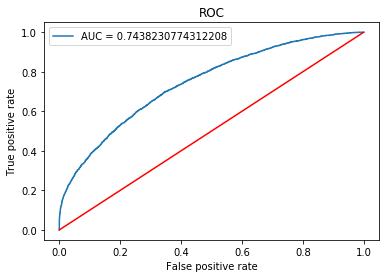

Test:
The model accuracy is 0.8789768523411902
The model f1 is 0.017167381974248927
The model p is 0.38461538461538464
The model recall is 0.00877963125548727
The model KS is 0.31685543612359346
The confusion matrix is:
 [[8306   16]
 [1129   10]]


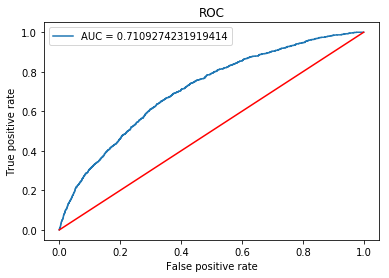

In [115]:
# 训练集
pre_train = model_cb.predict(x_train)
pro_train = model_cb.predict_proba(x_train)[:,1]
# 测试集
pre_test = model_cb.predict(x_test)
pro_test = model_cb.predict_proba(x_test)[:,1]

fpr, tpr, _ = model_performance(y_train, pre_train, pro_train, y_test, pre_test, pro_test)

(31534, 1)


C:\Users\15742\Anaconda35\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


count    31534.000000
mean       620.160380
std         30.807346
min        440.530273
25%        600.405556
50%        620.577269
75%        642.405949
max        694.858773
Name: score, dtype: float64

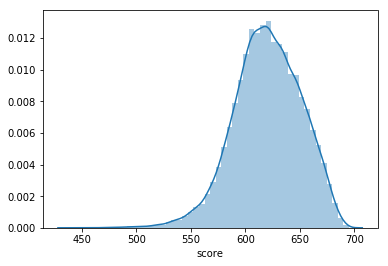

In [160]:
# 模型分数转换
all_pro = pd.concat([pd.Series(pro_train), pd.Series(pro_test)], axis=0)
score_cat = get_model_score(all_pro)
print(score_cat.shape)
# print('Max Score:%s' % max(score_cat.score))
# print('Min Score:%s' % min(score_cat.score))
# 分数整体分布图
sn.distplot(score_cat['score'])
score_cat['score'].describe()

<BarContainer object of 12 artists>

[Text(0,0,'emp_length'),
 Text(0,0,'purpose'),
 Text(0,0,'addr_state'),
 Text(0,0,'funded_amnt_inv'),
 Text(0,0,'int_rate'),
 Text(0,0,'annual_inc'),
 Text(0,0,'dti'),
 Text(0,0,'inq_last_6mths'),
 Text(0,0,'pub_rec'),
 Text(0,0,'revol_util'),
 Text(0,0,'pub_rec_bankruptcies'),
 Text(0,0,'pnt_loan_annual')]

Text(0.5,1,'CatBoost:Feature Importance')

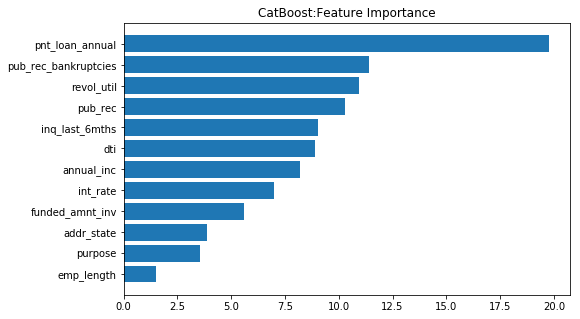

In [154]:
# 特征重要性
fimp_v = model_cb.get_feature_importance()
fimp_n = model_cb.feature_names_
fimp_vs = pd.Series(fimp_v).to_frame().rename(columns={0:'f_score'})
fimp_ns = pd.Series(fimp_n).to_frame().rename(columns={0:'f_name'})
fimp_result = pd.concat([fimp_ns, fimp_vs], axis=1)
fimp_result = fimp_result.sort_values(by='f_score')

fig = plt.figure(figsize=(8,5))
ax = fig.add_subplot(111)
ax.barh(range(len(fimp_result['f_score'])),fimp_result['f_score'])
ax.set_yticks(range(len(fimp_result['f_name'])))
ax.set_yticklabels(fimp_n)
plt.title('CatBoost:Feature Importance')
plt.show()

In [166]:
# ======== 4.2 xgboost模型 ======== 

In [181]:
model_lgb = lgb.LGBMClassifier(boosting_type='gbdt', objective='binary', num_leaves=50,
                                learning_rate=0.1, n_estimators=10, max_depth=5,
                                bagging_fraction=0.9, feature_fraction=0.9, reg_lambda=0.2)

In [ ]:
# cols = ["AIRLINE","FLIGHT_NUMBER","DESTINATION_AIRPORT","ORIGIN_AIRPORT"]
# for item in cols:
#     data[item] = data[item].astype("category").cat.codes +1